# ID1: Section B — Building an AI Model for Polymer Identification

**Assigned Polymer:** PET (Polyethylene terephthalate)

This notebook implements the data exploration, visualisation, and machine learning tasks required for Section B of the ID1 lab. NIR spectral data collected using the PlasTell spectrophotometer is processed, cleaned, and used to train k-Nearest Neighbours (kNN) classifiers for polymer identification.

**Data sources:**
- `synthetic_data.csv` — Synthetic PlasTell export for code development (NOT used in final ML models)
- `data_source2.csv` — Lab-provided reference spectra to combine with own data in Task 2.04

## Setup: Imports and Configuration

Before any analysis, we need to load the Python **libraries** (pre-written code packages) that provide the tools we'll use throughout:

| Library | What it does | Why we need it |
|---|---|---|
| `pandas` | Handles tabular data (like spreadsheets) | Loading CSV files, filtering columns, counting values |
| `numpy` | Fast maths on arrays of numbers | Calculating means, standard deviations, manipulating spectral arrays |
| `matplotlib` / `seaborn` | Plotting graphs and heatmaps | Visualising spectra, confusion matrices, PCA scatter plots |
| `ast` | Safely converts text strings to Python objects | The PlasTell CSV stores spectra as text like `"[54406, 54428, ...]"` — we need to convert these to actual number lists |
| `hashlib` | Generates unique "fingerprints" (hashes) for data | Used to detect duplicate spectra — two identical spectra will produce the same hash |
| `sklearn` | Machine learning toolkit | Train/test splitting, scaling, kNN classifiers, evaluation metrics |



In [1]:
# ── Data handling libraries ───────────────────────────────────────────────────
import pandas as pd          # For loading/manipulating CSV data as tables ("DataFrames")
import numpy as np           # For numerical operations on arrays (mean, std, etc.)

# ── Plotting libraries ───────────────────────────────────────────────────────
import matplotlib.pyplot as plt  # Core plotting library (line plots, scatter, bar charts)
import seaborn as sns            # Higher-level plotting built on matplotlib (heatmaps, styled plots)

# ── Utility libraries ────────────────────────────────────────────────────────
import ast                   # ast.literal_eval() safely converts a string like "[1, 2, 3]" into an actual Python list
import hashlib               # Generates SHA-256 hashes — a "digital fingerprint" to detect duplicate spectra
import csv                   # (Not actually used, but available for CSV manipulation if needed)
import os                    # For building file paths that work on any operating system

# ── Data structures ──────────────────────────────────────────────────────────
from collections import Counter  # Quickly counts how many times each item appears in a list

# ── Machine learning (scikit-learn) ──────────────────────────────────────────
from sklearn.model_selection import train_test_split   # Splits data into training set and test set
from sklearn.preprocessing import StandardScaler       # Centres and scales features to mean=0, std=1
from sklearn.neighbors import KNeighborsClassifier     # The kNN classification algorithm
from sklearn.metrics import confusion_matrix, classification_report  # Evaluate how well the model performed

# ── Reproducibility ──────────────────────────────────────────────────────────
# Many ML operations involve randomness (e.g., which spectra go into the
# training vs test set). Setting a "seed" fixes the random number generator
# so that every time you run this notebook, you get EXACTLY the same split,
# the same results, and the same plots. The number 42 is arbitrary — any
# integer would work — but using the same seed means your results are
# reproducible by anyone who runs this code. This is essential for scientific
# work: an examiner re-running your notebook should see identical output.
np.random.seed(42)

# ── File paths ───────────────────────────────────────────────────────────────
# os.path.join() builds file paths using the correct separator for your OS
# (/ on Mac/Linux, \ on Windows). The '.' means "current directory" — i.e.,
# the folder this notebook is saved in.
DATA_DIR = os.path.join('.', 'data')       # Where the raw input CSV files live
OUTPUT_DIR = os.path.join('.', 'output')   # Where we'll save processed/cleaned files

# Input file paths — these point to the two data sources described in cell 0
PLASTELL_CSV = os.path.join(DATA_DIR, 'synthetic_data.csv')      # Your PlasTell spectrophotometer export
DATA_SOURCE2_CSV = os.path.join(DATA_DIR, 'data_source2.csv')    # Lab-provided reference spectra

print('Setup complete.')

Setup complete.


---
## Activity 2: Exploring Your Data

### Task 2.01: Counting Spectra & Polymers from your .CSV File

**Objective:** Load the NIR spectral data from the PlasTell .CSV export, count the total number of spectra, and determine how many times each unique polymer appears in the dataset.

**Why this matters:** Before doing any analysis or machine learning, you need to know:
- **How much data you have** — too little data makes ML models unreliable.
- **How the data is distributed across classes** — if one polymer has 100 spectra and another has 3, the model will be biased towards the larger class (this is called **class imbalance**).

In [2]:
def count_spectra(filepath):
    """Load a CSV file and count how many spectra (rows) it contains.
    
    Each row in the PlasTell export represents one spectrum measurement
    taken from one polymer sample.
    """
    df = pd.read_csv(filepath)   # pd.read_csv() reads a CSV file into a DataFrame (table)
    total = len(df)              # len() counts the number of rows = number of spectra
    print(f'Total number of spectra: {total}.')
    return df                    # Return the DataFrame so we can use it in later tasks


def count_polymers(df):
    """Count how many spectra exist for each unique polymer type.
    
    The 'labelMaterialsString' column contains the polymer name (e.g., 'PET',
    'HDPE') for each spectrum. value_counts() tallies how many times each
    unique name appears — like doing a frequency count in a spreadsheet.
    """
    counts = df['labelMaterialsString'].value_counts()
    print(f'\nNumber of spectra for each unique polymer:')
    print(counts)
    return counts


# ── Run Task 2.01 ────────────────────────────────────────────────────────────
# Load the raw PlasTell data and count what we have
raw_df = count_spectra(PLASTELL_CSV)
polymer_counts = count_polymers(raw_df)

Total number of spectra: 35.

Number of spectra for each unique polymer:
labelMaterialsString
LDPE    5
HDPE    3
PMMA    3
PVC     3
PA6     3
PA66    3
PC      3
ABS     3
PP      3
PET     3
PS      3
Name: count, dtype: int64


The dataset contains spectra for several polymer types. The distribution shows whether the dataset is **balanced** (roughly equal numbers of each polymer) or **imbalanced** (some polymers hugely over- or under-represented).

**Why balance matters:** If PMMA has 100 spectra but ABS only has 5, a lazy model could predict "PMMA" for everything and still get ~95% accuracy — without actually learning to identify ABS. This is why we check the distribution early and address it later (see the Class Imbalance section).

### Task 2.02: Filtering and Saving Specific Data

**Objective:** Extract only the two columns we actually need — the polymer label and the spectrum data — and save them to a new, cleaner CSV file.

**Why we do this:** The raw PlasTell export contains many columns of metadata (timestamps, device info, scan settings, etc.) that are irrelevant for ML. Keeping only `labelMaterialsString` (the polymer name) and `spectrum` (the intensity values) removes clutter and reduces file size. Think of it like highlighting only the relevant columns in a spreadsheet and copying them to a new sheet.

In [3]:
def filter_and_save(df, output_path):
    """Keep only the polymer label and spectrum columns; discard everything else.
    
    .copy() creates an independent copy of the data so that changes to the
    filtered version don't accidentally modify the original DataFrame.
    """
    filtered = df[['labelMaterialsString', 'spectrum']].copy()  # Select just these 2 columns
    filtered.to_csv(output_path, index=False)                   # Save to CSV (index=False avoids adding a row-number column)
    print(f'Filtered data saved to: {output_path}')
    print(f'\nFirst 5 rows:')
    print(filtered.head())    # .head() shows the first 5 rows — a quick sanity check
    return filtered


# ── Run Task 2.02 ────────────────────────────────────────────────────────────
filtered_path = os.path.join(OUTPUT_DIR, '2.02_filtered-data.csv')
filtered_df = filter_and_save(raw_df, filtered_path)

Filtered data saved to: ./output/2.02_filtered-data.csv

First 5 rows:
  labelMaterialsString                                           spectrum
0                 HDPE  [54406, 54428, 54691, 55153, 55762, 56460, 571...
1                 HDPE  [54952, 54750, 54800, 55070, 55520, 56106, 567...
2                 HDPE  [49936, 49856, 50364, 51354, 52686, 54203, 557...
3                 LDPE  [51005, 50214, 49345, 48517, 47877, 47574, 477...
4                 LDPE  [48410, 47068, 45481, 43835, 42367, 41323, 409...


### Task 2.03: Transforming Spectrophotometer Data

**Objective:** Convert the raw data into a format suitable for analysis and ML.

**The problem:** In the PlasTell CSV, each spectrum is stored as a **text string** that looks like a Python list: `"[54406, 54428, 54691, ...]"`. Python can't do maths on text — we need to convert these strings into actual arrays of numbers.

**What this function does, step by step:**
1. Uses `ast.literal_eval()` to safely convert each text string into a real Python list of integers.
2. Calculates the **wavelength axis** — the PlasTell scans from 1550 nm to 1950 nm across 128 evenly-spaced points. `np.linspace(1550, 1950, 128)` generates these 128 wavelength values.
3. **Transposes** the data so that each row = one wavelength and each column = one spectrum. This is the standard format for spectral databases (wavelengths on the y-axis, samples along the x-axis).
4. Names each column by its polymer type (e.g., `HDPE`, `HDPE.01`, `HDPE.02`, ...) so we can identify which spectrum belongs to which polymer.

In [4]:
def transform_spectral_data(input_path, output_path):
    """Convert string-encoded spectra into a numeric wavelength x spectra table.
    
    Input format:  Each row has a polymer label and a spectrum stored as text.
    Output format: Each row is a wavelength (1550-1950 nm), each column is one spectrum.
    """
    df = pd.read_csv(input_path)
    
    # Step 1: Convert spectrum strings to actual Python lists of numbers
    # e.g., the string "[54406, 54428, ...]" becomes the list [54406, 54428, ...]
    df['spectrum'] = df['spectrum'].apply(ast.literal_eval)
    
    # Step 2: Calculate the wavelength axis
    # The PlasTell measures 128 intensity values evenly spaced from 1550 nm to 1950 nm
    num_points = len(df['spectrum'].iloc[0])           # How many points per spectrum (should be 128)
    wavelengths = np.linspace(1550, 1950, num_points)  # Generate 128 evenly-spaced wavelengths
    
    # Step 3: Build unique column names for each spectrum
    # First HDPE spectrum → "HDPE", second → "HDPE.01", third → "HDPE.02", etc.
    labels = df['labelMaterialsString'].values
    polymer_counter = {}   # Tracks how many spectra we've seen for each polymer
    column_names = []
    for label in labels:
        if label not in polymer_counter:
            polymer_counter[label] = 0
        polymer_counter[label] += 1
        count = polymer_counter[label]
        if count == 1:
            column_names.append(label)                      # First spectrum: just "HDPE"
        else:
            column_names.append(f'{label}.{count - 1:02d}')  # Subsequent: "HDPE.01", "HDPE.02", etc.
    
    # Step 4: Transpose so rows = wavelengths, columns = spectra
    # .tolist() converts each spectrum list into rows of a 2D array
    # .T transposes from (n_spectra, 128) to (128, n_spectra)
    spectra_array = np.array(df['spectrum'].tolist()).T
    result = pd.DataFrame(spectra_array, columns=column_names)
    result.insert(0, 'Wavelength (nm)', wavelengths)  # Add wavelength as the first column
    
    result.to_csv(output_path, index=False)
    print(f'Transformed data saved to: {output_path}')
    print(f'Shape: {result.shape[0]} wavelengths x {result.shape[1] - 1} spectra')
    print(f'\nFirst 5 rows:')
    print(result.head())
    return result


# ── Run Task 2.03 ────────────────────────────────────────────────────────────
transformed_path = os.path.join(OUTPUT_DIR, '2.03_transformed-data.csv')
transformed_df = transform_spectral_data(filtered_path, transformed_path)

Transformed data saved to: ./output/2.03_transformed-data.csv
Shape: 128 wavelengths x 35 spectra

First 5 rows:
   Wavelength (nm)   HDPE  HDPE.01  HDPE.02   LDPE  LDPE.01  LDPE.02  LDPE.03  \
0      1550.000000  54406    54952    49936  51005    48410    49854    36346   
1      1553.149606  54428    54750    49856  50214    47068    48883    35451   
2      1556.299213  54691    54800    50364  49345    45481    47705    34803   
3      1559.448819  55153    55070    51354  48517    43835    46495    34508   
4      1562.598425  55762    55520    52686  47877    42367    45471    34686   

   LDPE.04   PMMA  ...  ABS.02     PP  PP.01  PP.02    PET  PET.01  PET.02  \
0    52560  64437  ...   61641  59929  61678  63619  52982   51005   53484   
1    51117  64844  ...   62287  59816  61797  63670  53246   51274   53669   
2    49508  65036  ...   63014  59796  61885  63602  53581   51650   53838   
3    47909  65064  ...   63759  59897  61980  63474  54049   52202   54091   
4    46542

The data is now in the required transposed format: each row corresponds to a wavelength value (1550–1950 nm) and each column holds a single spectrum labelled by polymer type.

### Task 2.04: Combining Datasets

**Objective:** Merge your own PlasTell spectra with the lab-provided reference dataset (`data_source2.csv`) into one large combined database.

**Why we do this:** Your own PlasTell data only has ~35 spectra (3-5 per polymer). That's far too few for reliable ML. The lab-provided dataset adds ~335 more spectra, giving the model more examples to learn from. More data = better generalisation = more reliable predictions.

**How it works:** Both datasets have the same structure — 128 wavelength points from 1550-1950 nm — so we can simply stick them side-by-side (column-wise concatenation). We drop the duplicate wavelength column from the second dataset to avoid having it twice.

In [5]:
def combine_datasets(path1, path2, output_path):
    """Combine two spectral datasets side-by-side (column-wise).
    
    Both datasets must have the same number of rows (128 wavelengths).
    The wavelength column from dataset 2 is dropped to avoid duplication.
    """
    df1 = pd.read_csv(path1)   # Our transformed PlasTell data
    df2 = pd.read_csv(path2)   # The lab-provided reference spectra
    
    # Drop the wavelength column from dataset 2 — we already have it from dataset 1
    df2_spectra = df2.iloc[:, 1:]   # iloc[:, 1:] means "all rows, columns from index 1 onwards" (skipping column 0)
    
    # pd.concat with axis=1 joins tables side-by-side (adding columns)
    # axis=0 would stack them vertically (adding rows)
    combined = pd.concat([df1, df2_spectra], axis=1)
    combined.to_csv(output_path, index=False)
    
    print(f'Combined data saved to: {output_path}')
    print(f'Dataset 1: {df1.shape[1] - 1} spectra')       # -1 to exclude the wavelength column
    print(f'Dataset 2: {df2_spectra.shape[1]} spectra')
    print(f'Combined: {combined.shape[1] - 1} total spectra')
    return combined


# ── Run Task 2.04 ────────────────────────────────────────────────────────────
combined_path = os.path.join(OUTPUT_DIR, '2.04_combined-data.csv')
combined_df = combine_datasets(transformed_path, DATA_SOURCE2_CSV, combined_path)

Combined data saved to: ./output/2.04_combined-data.csv
Dataset 1: 35 spectra
Dataset 2: 335 spectra
Combined: 370 total spectra


### Task 2.05: Counting Columns by Polymer

**Objective:** Now that we've combined both datasets, count how many spectra we have for each polymer type.

**How column names encode the polymer:** Each column is named like `POLYMER` or `POLYMER.XX` (e.g., `PMMA`, `PMMA.01`, `PMMA.02`). By splitting on the `.` character and taking the first part, we extract the polymer name. Then `Counter` tallies up the totals — this is our "class distribution" for ML.

In [6]:
def count_columns_by_polymer(filepath):
    """Count how many spectra columns exist for each polymer type.
    
    Column names like 'PMMA.05' are split on '.' to extract just 'PMMA'.
    Counter then tallies how many columns share each polymer prefix.
    """
    df = pd.read_csv(filepath)
    headers = df.columns[1:]  # Skip the first column (wavelength) — everything else is a spectrum
    
    # Extract polymer name from each column header
    # 'PMMA.05'.split('.')[0] → 'PMMA'
    # 'PET'.split('.')[0] → 'PET' (still works even without a dot)
    prefixes = [h.split('.')[0] for h in headers]
    counts = Counter(prefixes)  # Counter({'PMMA': 118, 'PVC': 73, ...})
    
    print(f'Total number of spectra columns: {len(headers)}')
    print(f'\nSpectra count per polymer type:')
    for polymer, count in sorted(counts.items()):
        print(f'  {polymer}: {count}')
    return counts


# ── Run Task 2.05 ────────────────────────────────────────────────────────────
polymer_column_counts = count_columns_by_polymer(combined_path)

Total number of spectra columns: 370

Spectra count per polymer type:
  ABS: 8
  HDPE: 29
  LDPE: 20
  PA6: 13
  PA66: 23
  PC: 17
  PET: 21
  PMMA: 118
  PP: 28
  PS: 20
  PVC: 73


Imbalanced polymer representation can bias the kNN model towards over-represented classes. If significant imbalances exist, strategies such as undersampling, oversampling, or stratified splitting should be considered.

### Task 2.06: Looking for Duplicates

**Objective:** Detect and remove spectra that are exact copies of each other.

**Why duplicates are a problem:** When we combined datasets (Task 2.04), some spectra from our PlasTell data may already exist in the lab-provided dataset — they'd be counted twice. Duplicates artificially inflate the dataset and bias the ML model by over-representing those particular measurements.

**How we detect them — SHA-256 hashing:**
- A **hash function** takes any data and produces a fixed-length "fingerprint" string (e.g., `a3f5b2c1...`).
- If two spectra contain **exactly the same** 128 intensity values, they produce **the same hash**.
- If even a single value differs, the hashes will be completely different.
- This lets us efficiently compare hundreds of spectra without checking every value pair-by-pair.

We keep the first copy and remove all subsequent duplicates.

In [7]:
def compute_hash(spectrum_values):
    """Generate a unique SHA-256 fingerprint for a single spectrum.
    
    Converts the 128 intensity values to a string, then feeds it through
    the SHA-256 algorithm to produce a 64-character hex digest. Two spectra
    with identical values will always produce the same hash.
    """
    data_string = str(spectrum_values.tolist())                     # Convert array to string: "[54406, 54428, ...]"
    return hashlib.sha256(data_string.encode('utf-8')).hexdigest()  # Hash it → 64-char hex string


def find_and_remove_duplicates(filepath, output_path):
    """Find spectra that are exact copies and remove the duplicates.
    
    Strategy: Hash each spectrum column. If two columns share the same hash,
    they contain identical data. Keep the first occurrence, drop the rest.
    """
    df = pd.read_csv(filepath)
    spectra_columns = df.columns[1:]  # Everything except the wavelength column
    
    # Build a dictionary: hash → list of column names that share that hash
    hash_dict = {}
    for col in spectra_columns:
        h = compute_hash(df[col])
        if h not in hash_dict:
            hash_dict[h] = []
        hash_dict[h].append(col)
    
    # Any hash with more than one column = those columns are duplicates
    duplicates = {h: cols for h, cols in hash_dict.items() if len(cols) > 1}
    
    if duplicates:
        print('Duplicate spectra found:')
        columns_to_drop = []
        for h, cols in duplicates.items():
            print(f'  Columns with identical spectra: {cols}')
            columns_to_drop.extend(cols[1:])   # Keep the first, mark the rest for removal
        
        df_cleaned = df.drop(columns=columns_to_drop)  # Remove duplicate columns
        print(f'\nRemoved {len(columns_to_drop)} duplicate column(s).')
    else:
        print('No duplicate spectra found.')
        df_cleaned = df
    
    df_cleaned.to_csv(output_path, index=False)
    print(f'Duplicate-checked data saved to: {output_path}')
    print(f'Remaining spectra: {df_cleaned.shape[1] - 1}')
    return df_cleaned


# ── Run Task 2.06 ────────────────────────────────────────────────────────────
dup_checked_path = os.path.join(OUTPUT_DIR, '2.06_duplicate-checked-data.csv')
dup_checked_df = find_and_remove_duplicates(combined_path, dup_checked_path)

Duplicate spectra found:
  Columns with identical spectra: ['HDPE', 'HDPE.12']
  Columns with identical spectra: ['HDPE.01', 'HDPE.13']
  Columns with identical spectra: ['HDPE.02', 'HDPE.14']
  Columns with identical spectra: ['LDPE', 'LDPE.15']
  Columns with identical spectra: ['LDPE.01', 'LDPE.1']
  Columns with identical spectra: ['LDPE.02', 'LDPE.2']
  Columns with identical spectra: ['LDPE.03', 'LDPE.3']
  Columns with identical spectra: ['LDPE.04', 'LDPE.4']
  Columns with identical spectra: ['PMMA', 'PMMA.115']
  Columns with identical spectra: ['PMMA.01', 'PMMA.1']
  Columns with identical spectra: ['PMMA.02', 'PMMA.2']
  Columns with identical spectra: ['PVC', 'PVC.70']
  Columns with identical spectra: ['PVC.01', 'PVC.1']
  Columns with identical spectra: ['PVC.02', 'PVC.2']
  Columns with identical spectra: ['PA6', 'PA6.10']
  Columns with identical spectra: ['PA6.01', 'PA6.1']
  Columns with identical spectra: ['PA6.02', 'PA6.2']
  Columns with identical spectra: ['PA66',

### Task 2.07: Checking for Invalid Values in Transformed Data

**Objective:** Scan every data point in the dataset for **missing values** (NaN) and **non-numeric entries** (e.g., the word `"none"` appearing where a number should be).

**Why this matters:** ML algorithms require clean numerical input. If even one cell contains text like `"none"` instead of a number, the model will crash or produce nonsensical results. The lab-provided `data_source2.csv` is known to contain some `"none"` entries.

**How we fix invalid values — median imputation:**
- We replace each invalid value with the **median** of its column (i.e., the middle value when all valid intensity readings at that wavelength are sorted).
- **Why median, not mean?** The median is robust to outliers. If one reading is abnormally high (e.g., a sensor glitch), the mean would be pulled toward that extreme value, but the median would barely change. This preserves the typical spectral shape more faithfully.

In [8]:
def check_and_fix_invalid_values(filepath, output_path):
    """Scan for missing/non-numeric values and replace them with the column median.
    
    Two types of problems are checked:
    1. NaN (Not a Number) — empty cells or values that pandas couldn't parse
    2. Non-numeric strings — e.g., "none" appearing where a number should be
    
    Both are replaced with the column's median value (median imputation).
    """
    df = pd.read_csv(filepath)
    issues_found = False
    
    for col in df.columns[1:]:  # Skip the wavelength column — only check spectrum columns
        # Check 1: Are there any NaN (missing) values?
        nan_mask = df[col].isna()          # Creates True/False for each cell: True = missing
        if nan_mask.any():                  # .any() returns True if at least one cell is NaN
            issues_found = True
            nan_rows = df.index[nan_mask].tolist()
            print(f'  Missing value (NaN) in column "{col}" at row(s): {[r + 2 for r in nan_rows]}')
        
        # Check 2: Are there any values that look like numbers but are actually text?
        for idx, value in df[col].items():
            if pd.isna(value):
                continue                    # Already flagged above, skip it
            try:
                float(value)                # Try converting to a number
            except (ValueError, TypeError):  # If this fails, it's not a valid number
                issues_found = True
                print(f'  Non-numeric value "{value}" in column "{col}" at row {idx + 2}')
                df.at[idx, col] = np.nan    # Mark it as NaN so we can impute it below
    
    if not issues_found:
        print('No invalid values found.')
    else:
        # Replace all NaN values with the column median
        print('\nImputing invalid values with column median...')
        for col in df.columns[1:]:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Force everything to numbers (non-numeric → NaN)
            if df[col].isna().any():
                median_val = df[col].median()                   # Calculate the median of valid values
                df[col] = df[col].fillna(median_val)            # Replace NaN with median
                print(f'  Column "{col}": filled with median = {median_val:.1f}')
    
    df.to_csv(output_path, index=False)
    print(f'\nChecked data saved to: {output_path}')
    return df


# ── Run Task 2.07 ────────────────────────────────────────────────────────────
checked_path = os.path.join(OUTPUT_DIR, '2.07_checked-data.csv')
checked_df = check_and_fix_invalid_values(dup_checked_path, checked_path)

  Non-numeric value "none" in column "HDPE.5" at row 6
  Non-numeric value "none" in column "HDPE.5" at row 11

Imputing invalid values with column median...
  Column "HDPE.5": filled with median = 46297.5

Checked data saved to: ./output/2.07_checked-data.csv


Median imputation was chosen because it is robust to outliers — unlike the mean, a single extreme value will not distort the imputed result. Alternatively, the entire column could be discarded if too many values are invalid.

---
## Activity 3: Visualising Your Data

### Task 3.01: Visualisation of Central Tendency & Dispersion

**Objective:** For each polymer type, calculate the **mean spectrum** (average shape) and **standard deviation** (how much individual spectra vary from the average), then plot both.

**Why this matters:**
- The **mean spectrum** shows the "typical" NIR signature for each polymer — this is what the ML model is essentially trying to learn for each class.
- The **standard deviation** (shown as a shaded band around the mean) shows how much **variation** exists within each polymer class. Large variation = harder for the model to learn a clear pattern.
- If two polymers' mean spectra look very similar, the model will struggle to tell them apart.

**Why we use the mean (not the median) here:** For continuous spectral intensity data that is roughly symmetrically distributed at each wavelength, the mean is a good summary. (We used the median earlier for *imputation* because it's more robust to extreme outliers — different use case.)

**Why the x-axis is reversed:** In spectroscopy, it's convention to plot with higher wavenumbers (shorter wavelengths) on the left. Since we're plotting wavelength in nm, reversing the axis follows this convention.

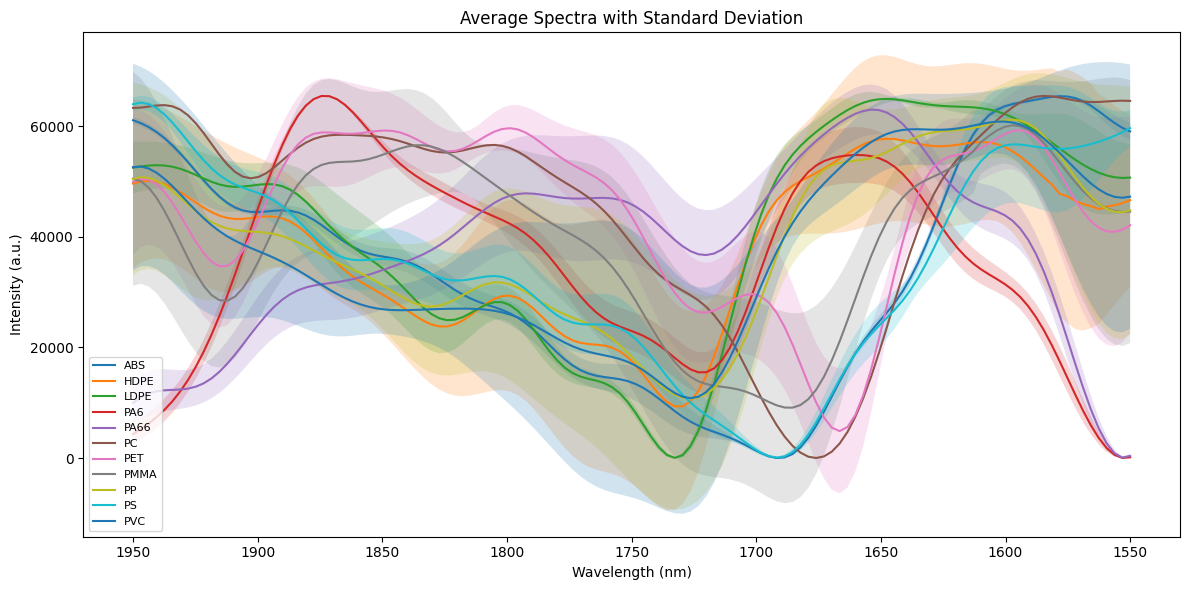

Averaged data saved to: ./output/3.01_averaged-data.csv


In [9]:
def extract_prefix(column_name):
    """Extract the polymer name from a column header.
    
    Examples:
        'PET'    → 'PET'     (no dot, returns the whole name)
        'PET.03' → 'PET'     (splits on '.', returns the first part)
        'PMMA.105' → 'PMMA'
    
    This is used throughout the notebook whenever we need to group
    spectra by their polymer type.
    """
    return column_name.split('.')[0]


def plot_average_spectra(filepath, output_csv_path):
    """Calculate and plot the mean spectrum +/- standard deviation for each polymer.
    
    For each polymer group:
    1. Collect all spectra belonging to that polymer
    2. Calculate the mean intensity at each wavelength (the average shape)
    3. Calculate the standard deviation at each wavelength (the spread)
    4. Plot the mean as a line and the +/- 1 std dev as a shaded band
    """
    df = pd.read_csv(filepath)
    wavelengths = df.iloc[:, 0].values   # First column = wavelength values (1550-1950 nm)
    spectra_columns = df.columns[1:]     # All other columns = individual spectra
    
    # Group columns by polymer prefix (e.g., all PMMA columns together)
    groups = {}
    for col in spectra_columns:
        prefix = extract_prefix(col)
        if prefix not in groups:
            groups[prefix] = []
        groups[prefix].append(col)
    
    # Calculate mean and std for each polymer group, and plot
    results = {'Wavelength (nm)': wavelengths}
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for polymer in sorted(groups.keys()):
        cols = groups[polymer]
        # Convert to numeric (in case any strings remain), shape: (128 wavelengths, n_spectra)
        data = df[cols].apply(pd.to_numeric, errors='coerce').values
        mean_spectrum = np.nanmean(data, axis=1)  # Average across spectra at each wavelength
        std_spectrum = np.nanstd(data, axis=1)    # Std dev across spectra at each wavelength
        
        results[f'{polymer}_mean'] = mean_spectrum
        results[f'{polymer}_std'] = std_spectrum
        
        # Plot the mean line
        ax.plot(wavelengths, mean_spectrum, label=polymer)
        # Plot the shaded band showing +/- 1 standard deviation
        ax.fill_between(wavelengths,
                        mean_spectrum - std_spectrum,    # Lower bound
                        mean_spectrum + std_spectrum,    # Upper bound
                        alpha=0.2)                       # alpha=0.2 makes it semi-transparent
    
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Intensity (a.u.)')         # a.u. = arbitrary units (PlasTell raw counts)
    ax.set_title('Average Spectra with Standard Deviation')
    ax.legend(loc='best', fontsize=8)
    ax.invert_xaxis()                          # Spectroscopy convention: high wavenumber on left
    plt.tight_layout()
    plt.show()
    
    # Save the averaged data to CSV for reference
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv_path, index=False)
    print(f'Averaged data saved to: {output_csv_path}')
    return results_df


# ── Run Task 3.01 ────────────────────────────────────────────────────────────
averaged_path = os.path.join(OUTPUT_DIR, '3.01_averaged-data.csv')
averaged_df = plot_average_spectra(checked_path, averaged_path)

The plot shows that different polymers have distinct spectral signatures, particularly in the 1650–1850 nm region. Large error bars may indicate measurement variability or outlier spectra within that polymer class.

### Task 3.02: Using Heatmaps to Explore Spectra Variation

**Objective:** Generate per-polymer heatmaps of min-max normalised spectra and programmatically identify outlier spectra for removal. Each row is an individual spectrum and each column is a wavelength. Normalisation ensures all spectra are on the same 0–1 scale for fair comparison.

**Outlier detection method — Pearson correlation to group mean:**

Rather than relying solely on visual inspection of heatmaps, outliers are detected quantitatively using the following approach:

1. For each polymer group, the **mean spectrum** is calculated across all spectra in that group.
2. The **Pearson correlation coefficient** is computed between each individual spectrum and its group mean. This measures how well the shape of each spectrum matches the typical shape for that polymer — a value of +1.0 means a perfect match, 0 means no relationship, and negative values indicate an inverted spectral pattern.
3. Within each polymer group, a **z-score** is calculated for each correlation value. Spectra with z-scores below -2 (i.e., more than 2 standard deviations below the group average correlation) are flagged as statistical outliers.
4. Any spectrum with a **negative correlation** to its group mean is also flagged, as this indicates an inverted or fundamentally different spectral shape that is physically inconsistent with the polymer label.
5. As a safeguard, polymer groups where **all spectra have correlations above 0.999** are excluded from flagging, since any z-score outliers in such groups are statistical artifacts rather than genuine anomalies.

This approach is more objective and reproducible than purely visual inspection. Outlier rows are highlighted in red on the heatmaps for visual confirmation, and the flagged spectra are automatically removed before saving the cleaned dataset.

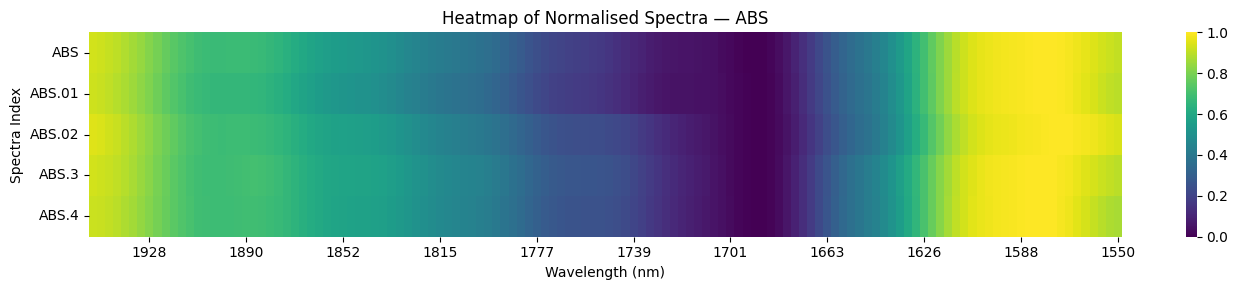

  ABS: no outliers detected.


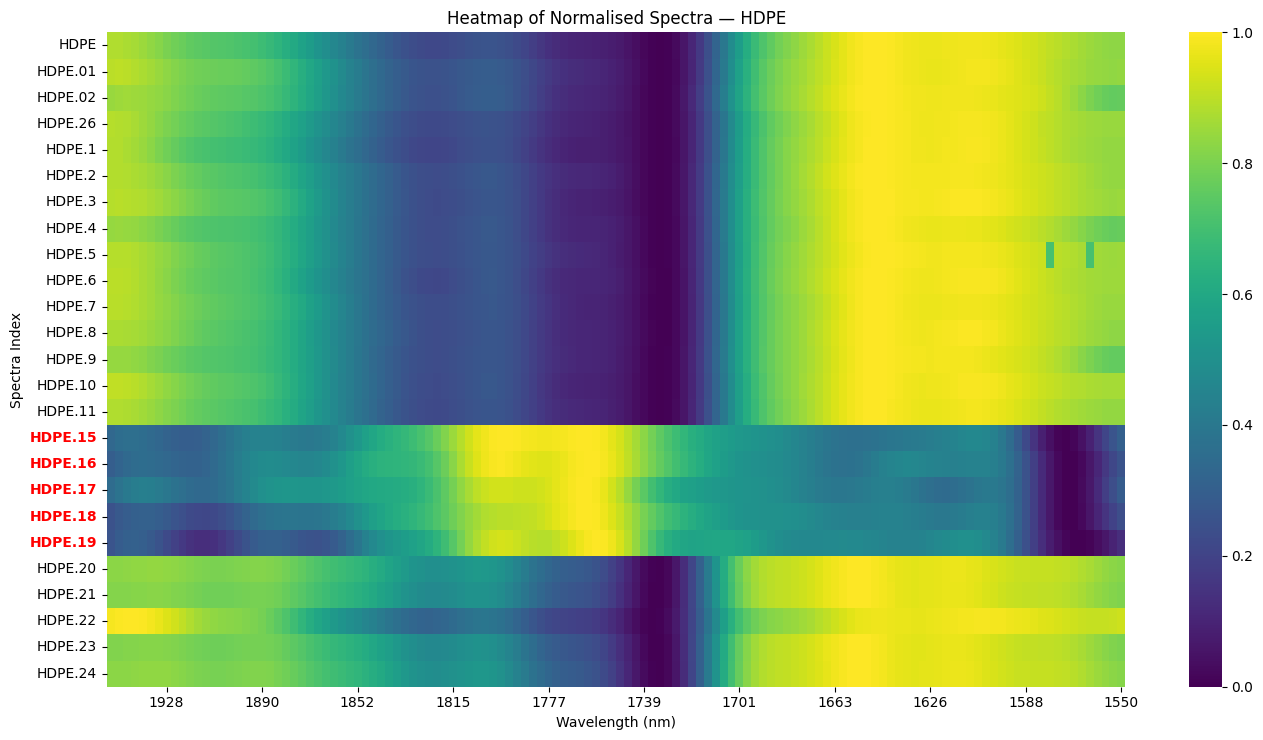

  HDPE: 5 outlier(s) detected:
    - HDPE.15 (correlation = -0.7494)
    - HDPE.16 (correlation = -0.7503)
    - HDPE.17 (correlation = -0.7314)
    - HDPE.18 (correlation = -0.7183)
    - HDPE.19 (correlation = -0.6187)


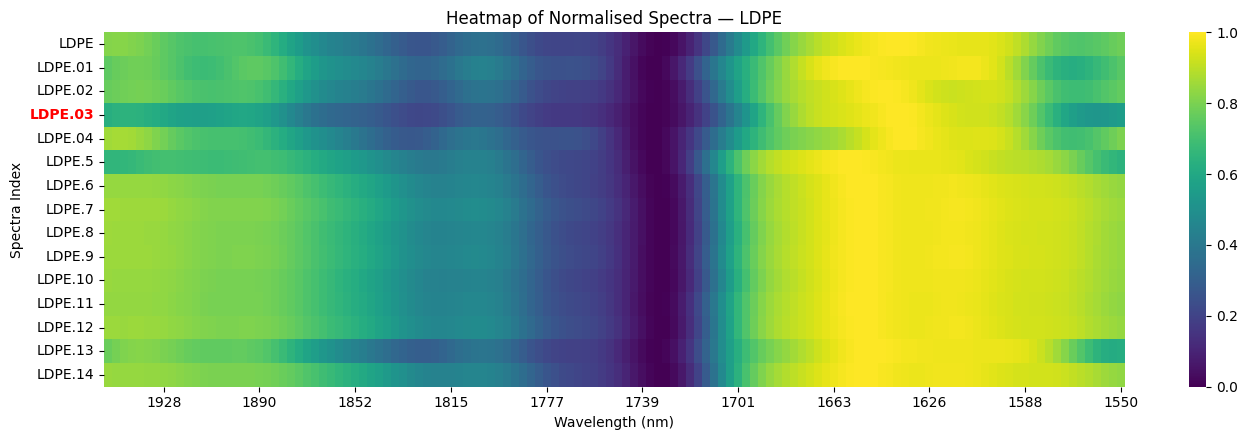

  LDPE: 1 outlier(s) detected:
    - LDPE.03 (correlation = 0.9622)


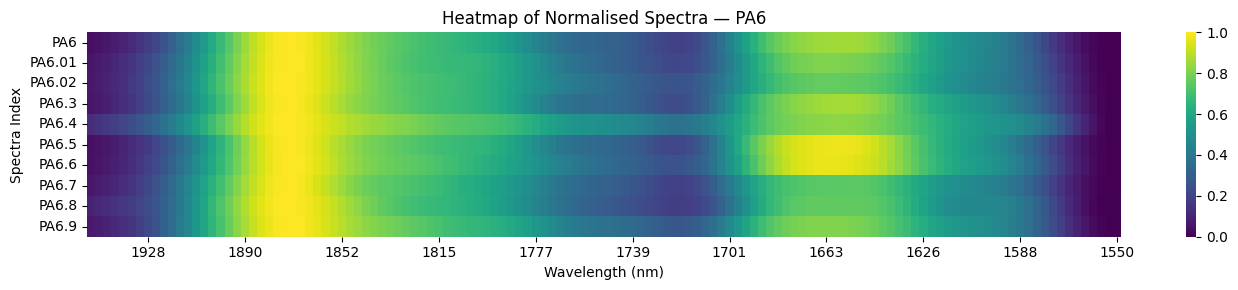

  PA6: no outliers detected.


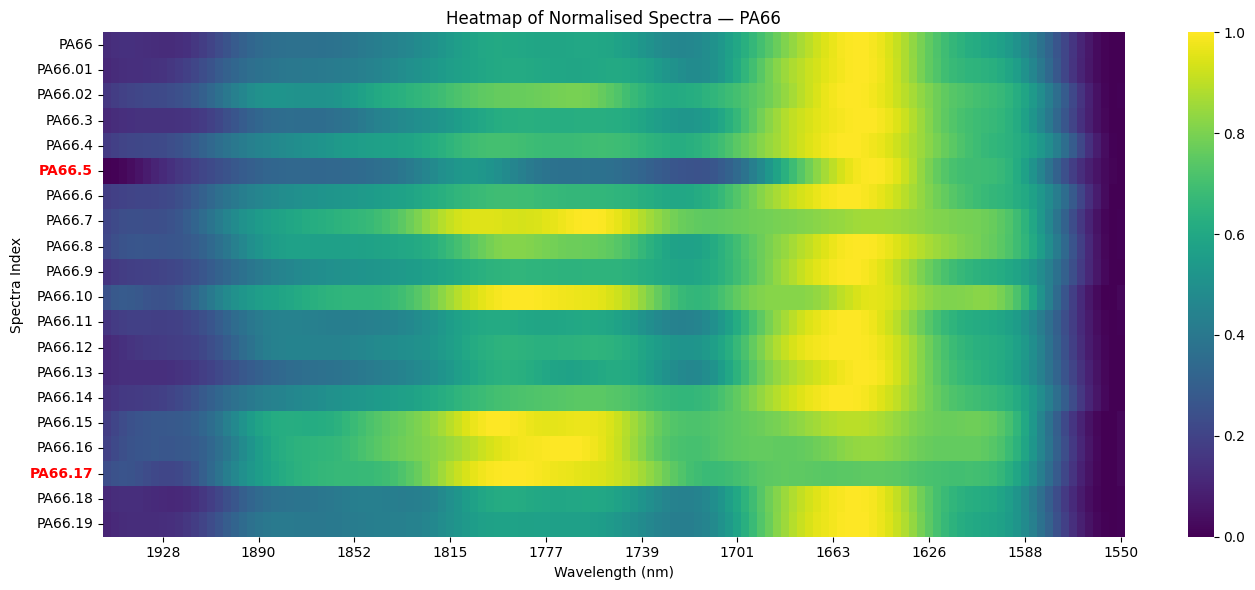

  PA66: 2 outlier(s) detected:
    - PA66.5 (correlation = 0.8674)
    - PA66.17 (correlation = 0.8491)


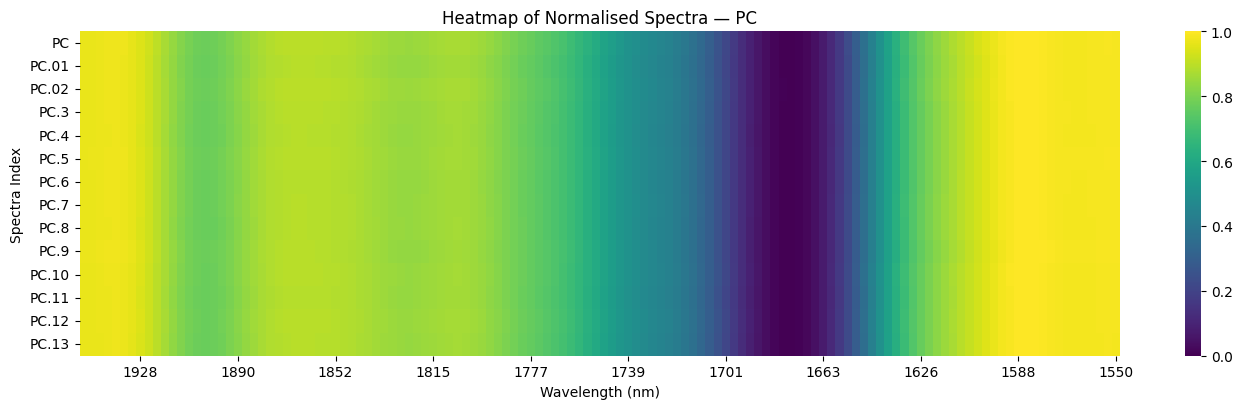

  PC: no outliers detected.


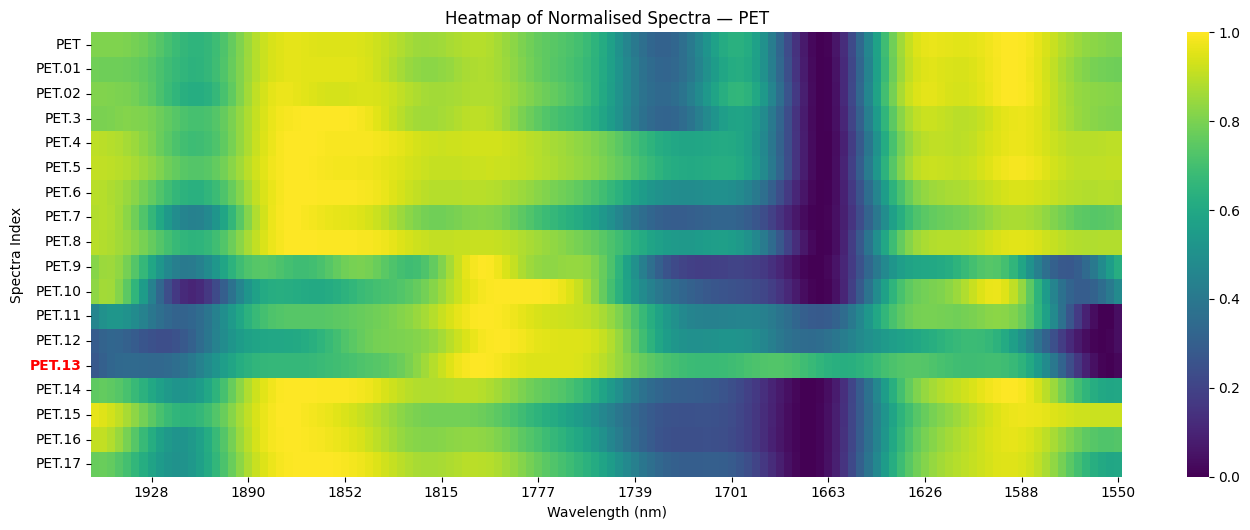

  PET: 1 outlier(s) detected:
    - PET.13 (correlation = 0.1929)


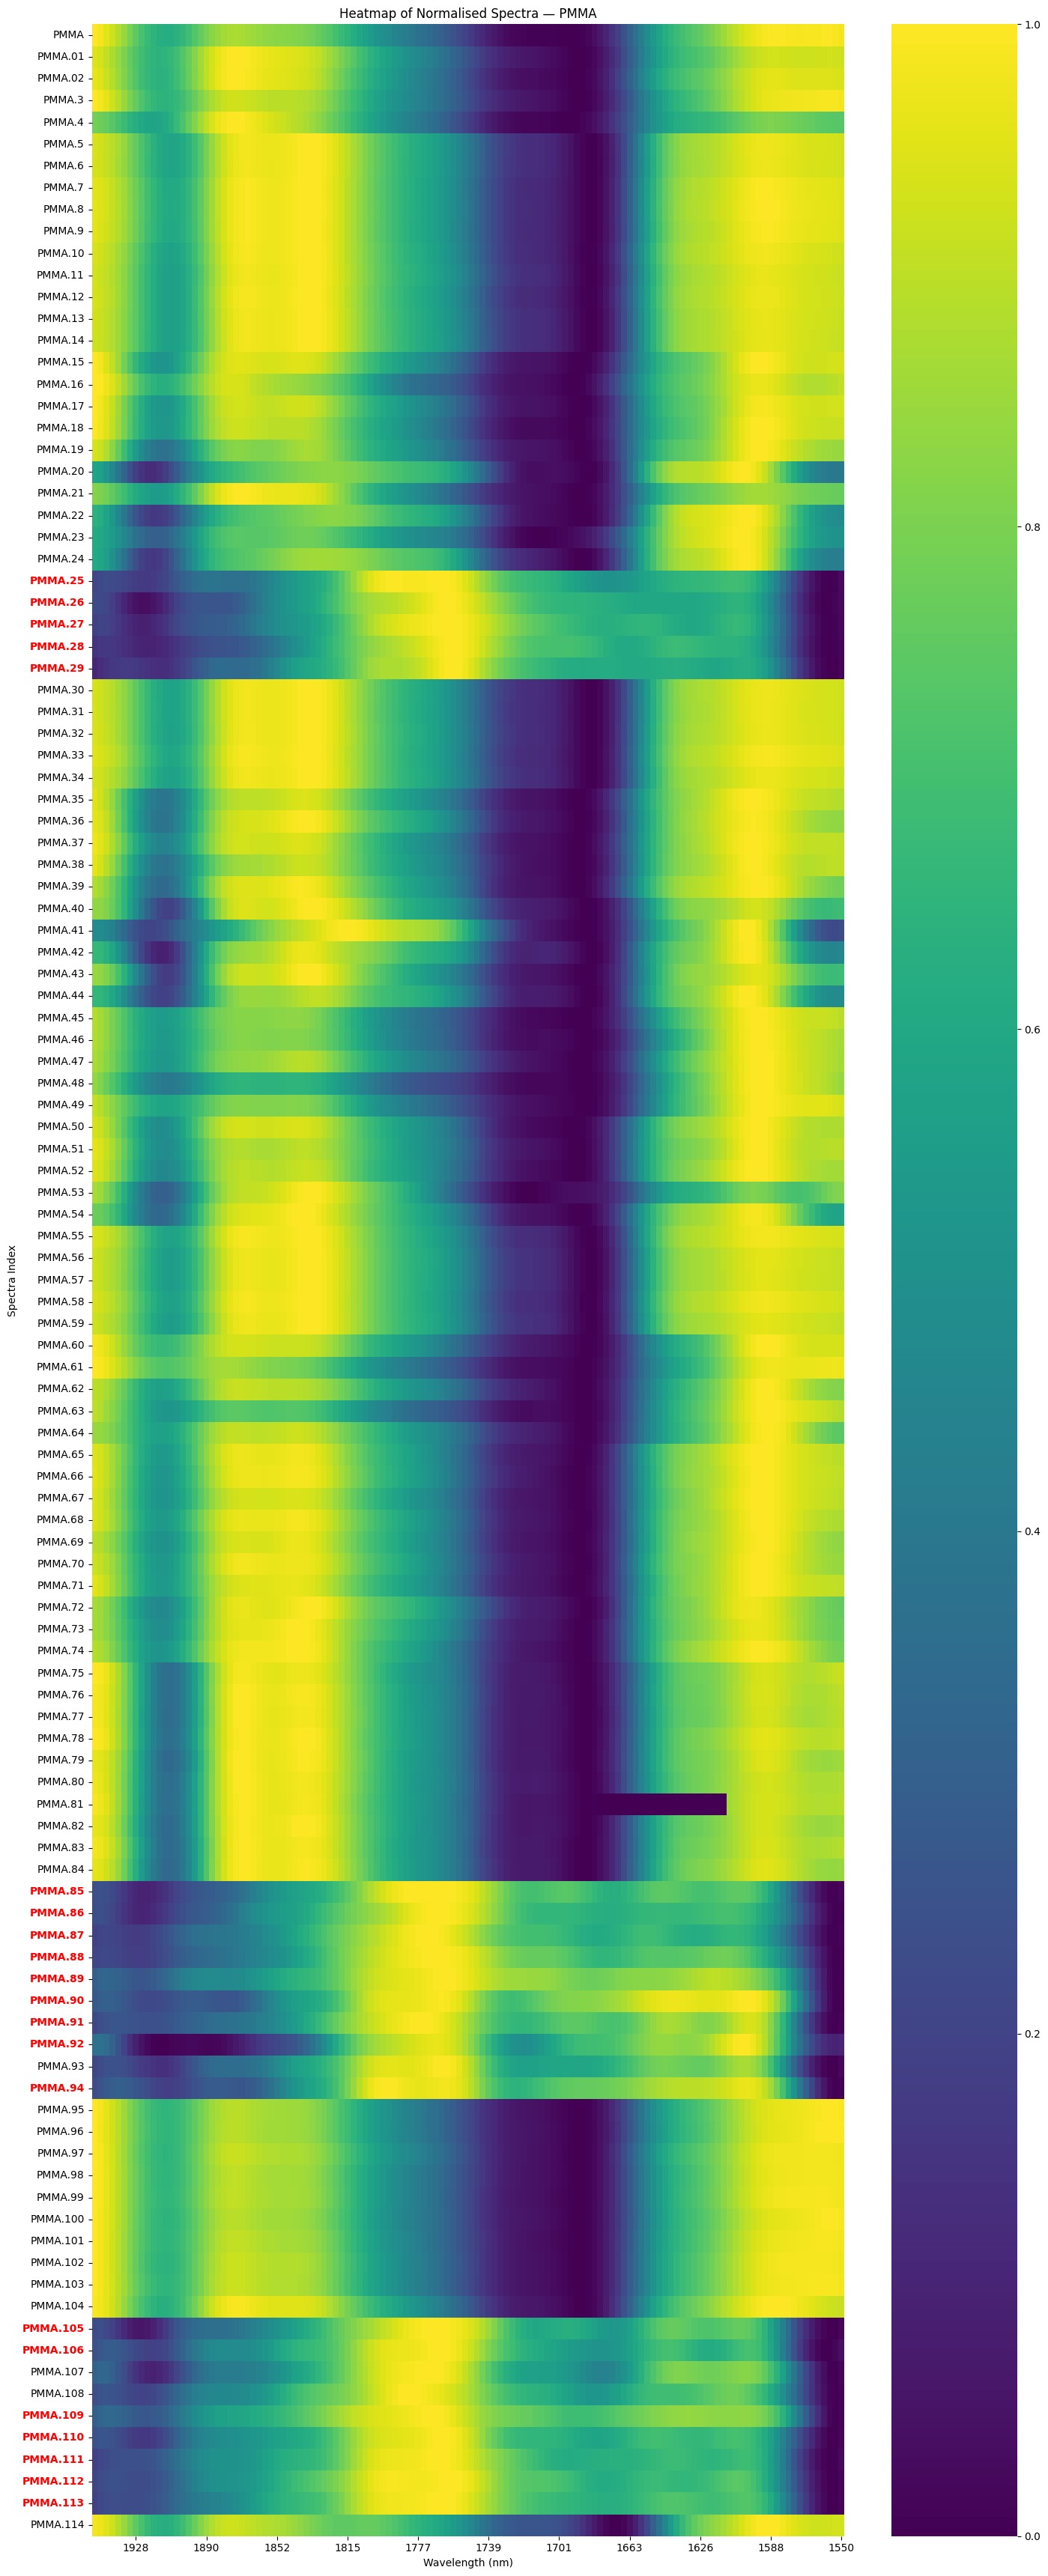

  PMMA: 21 outlier(s) detected:
    - PMMA.25 (correlation = -0.0973)
    - PMMA.26 (correlation = -0.2093)
    - PMMA.27 (correlation = -0.2473)
    - PMMA.28 (correlation = -0.2605)
    - PMMA.29 (correlation = -0.1995)
    - PMMA.85 (correlation = -0.1580)
    - PMMA.86 (correlation = -0.1320)
    - PMMA.87 (correlation = -0.1595)
    - PMMA.88 (correlation = -0.1790)
    - PMMA.89 (correlation = -0.1851)
    - PMMA.90 (correlation = -0.0940)
    - PMMA.91 (correlation = -0.0513)
    - PMMA.92 (correlation = -0.0333)
    - PMMA.94 (correlation = -0.0687)
    - PMMA.105 (correlation = -0.0384)
    - PMMA.106 (correlation = -0.0021)
    - PMMA.109 (correlation = -0.0120)
    - PMMA.110 (correlation = -0.0630)
    - PMMA.111 (correlation = -0.1139)
    - PMMA.112 (correlation = -0.1045)
    - PMMA.113 (correlation = -0.0921)


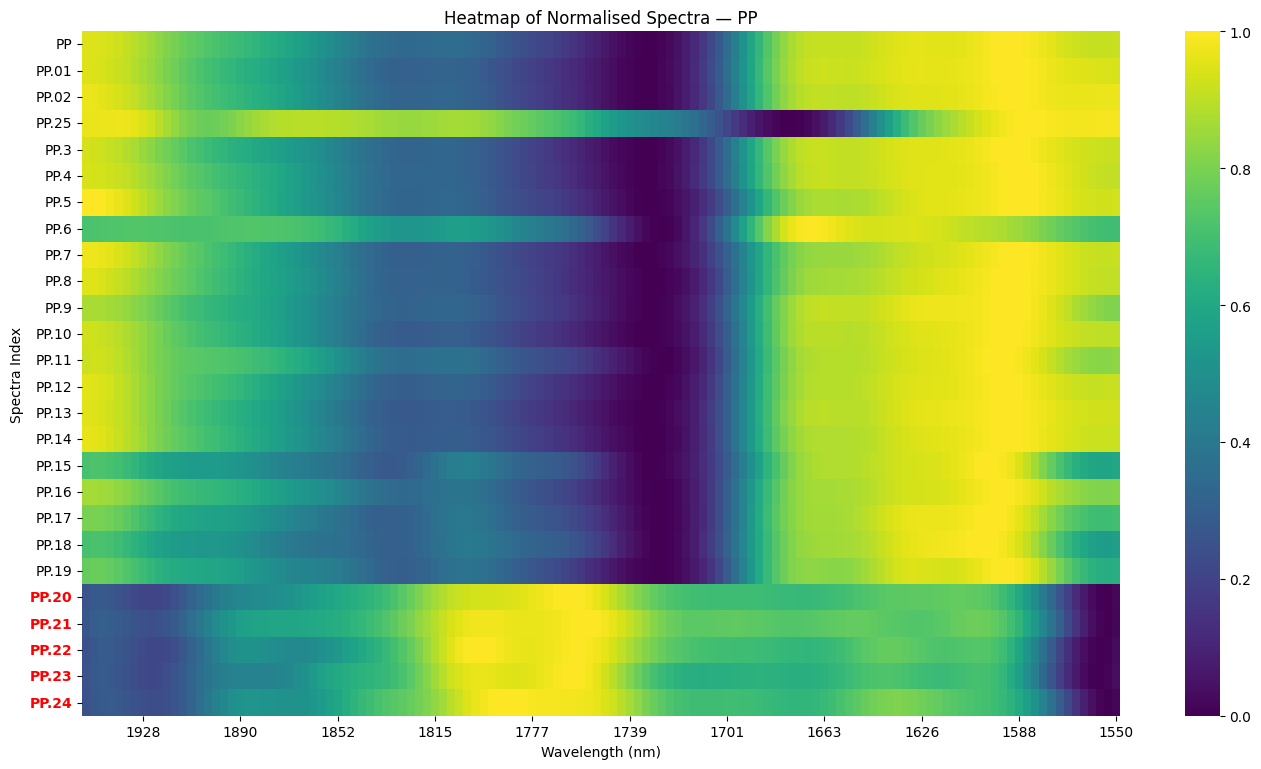

  PP: 5 outlier(s) detected:
    - PP.20 (correlation = -0.3797)
    - PP.21 (correlation = -0.4054)
    - PP.22 (correlation = -0.4001)
    - PP.23 (correlation = -0.3979)
    - PP.24 (correlation = -0.3796)


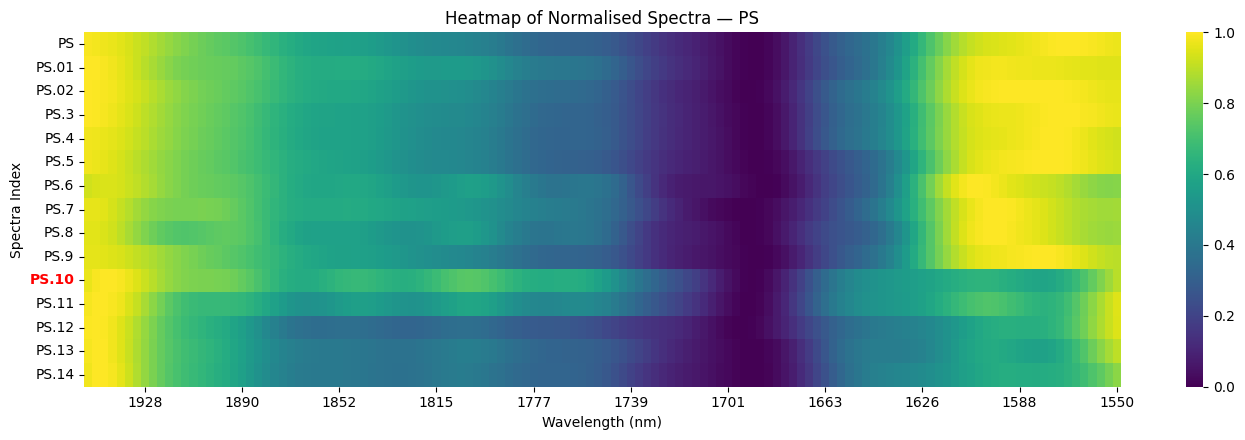

  PS: 1 outlier(s) detected:
    - PS.10 (correlation = 0.8657)


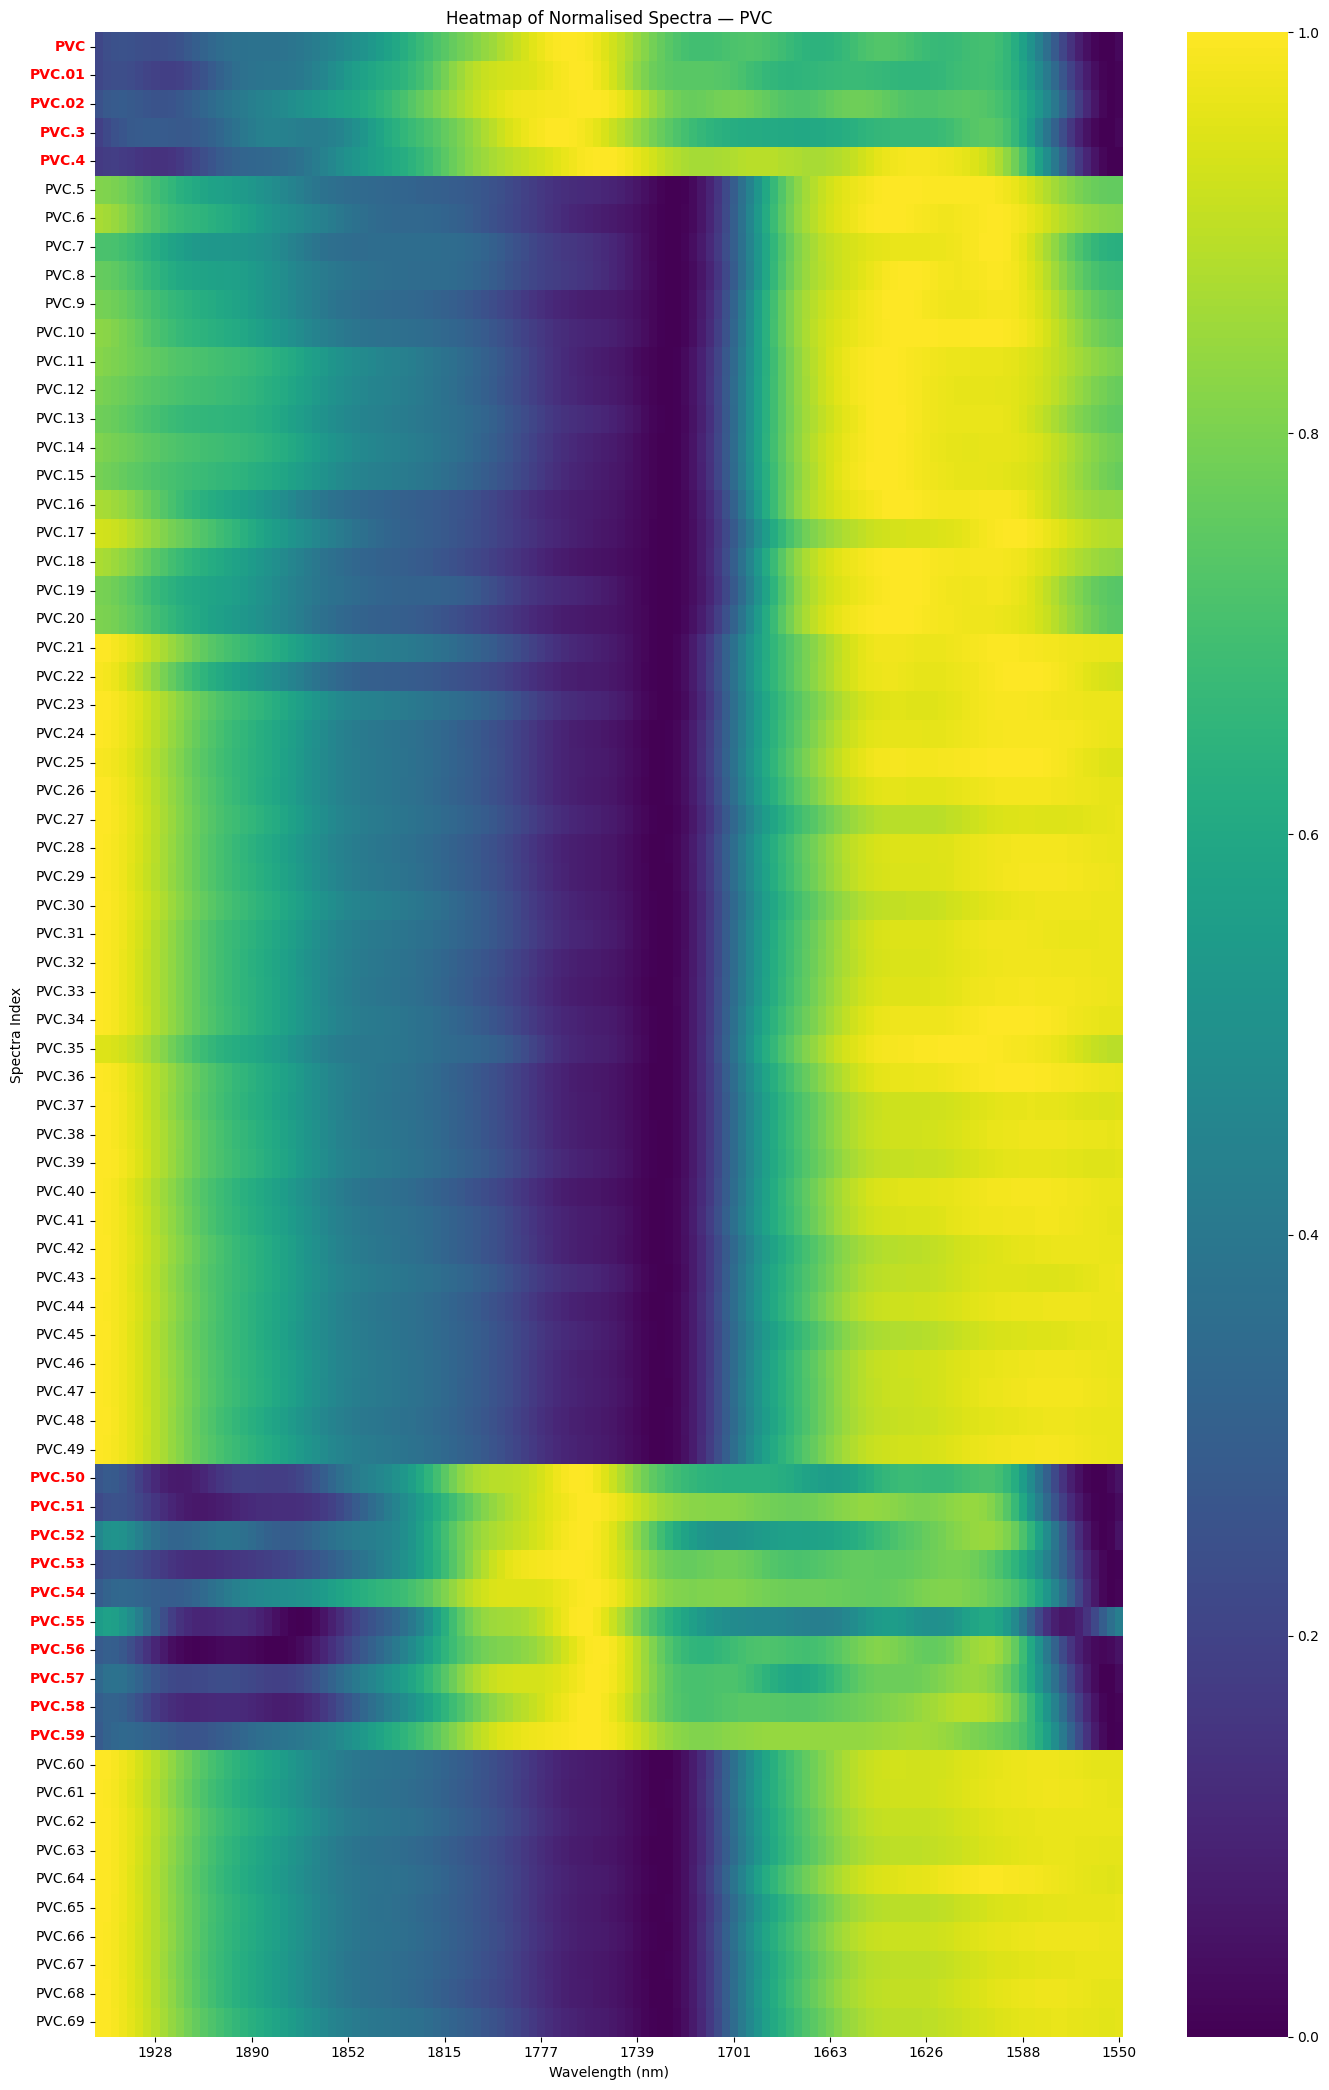

  PVC: 15 outlier(s) detected:
    - PVC (correlation = -0.4114)
    - PVC.01 (correlation = -0.4497)
    - PVC.02 (correlation = -0.4295)
    - PVC.3 (correlation = -0.4294)
    - PVC.4 (correlation = -0.1716)
    - PVC.50 (correlation = -0.3546)
    - PVC.51 (correlation = -0.1942)
    - PVC.52 (correlation = -0.1858)
    - PVC.53 (correlation = -0.2561)
    - PVC.54 (correlation = -0.3690)
    - PVC.55 (correlation = -0.3303)
    - PVC.56 (correlation = -0.1089)
    - PVC.57 (correlation = -0.2328)
    - PVC.58 (correlation = -0.0972)
    - PVC.59 (correlation = -0.2544)

OUTLIER DETECTION SUMMARY
Method: Pearson correlation to group mean (z < -2 or r < 0)
Total outliers detected: 51
  HDPE: 5 — ['HDPE.15', 'HDPE.16', 'HDPE.17', 'HDPE.18', 'HDPE.19']
  LDPE: 1 — ['LDPE.03']
  PA66: 2 — ['PA66.5', 'PA66.17']
  PET: 1 — ['PET.13']
  PMMA: 21 — ['PMMA.25', 'PMMA.26', 'PMMA.27', 'PMMA.28', 'PMMA.29', 'PMMA.85', 'PMMA.86', 'PMMA.87', 'PMMA.88', 'PMMA.89', 'PMMA.90', 'PMMA.91', 'PMMA.92',

In [10]:
from scipy.stats import pearsonr


def detect_outliers_correlation(data, cols, z_threshold=-2.0):
    """Detect outlier spectra using Pearson correlation to group mean.
    
    Each spectrum is correlated with the group mean spectrum. Spectra with
    z-scores below the threshold or with negative correlations are flagged
    as outliers. Groups where all correlations exceed 0.999 are skipped
    (flags in such groups are statistical artifacts, not real outliers).
    
    Args:
        data: array of shape (n_spectra, n_wavelengths), raw intensity values.
        cols: list of column names corresponding to each spectrum.
        z_threshold: z-score cutoff for flagging (default -2.0).
    
    Returns:
        outlier_names: list of column names identified as outliers.
        correlations: dict mapping column name to its Pearson correlation.
    """
    mean_spectrum = np.nanmean(data, axis=0)
    
    # Compute Pearson correlation of each spectrum to the group mean
    correlations = {}
    for i, col in enumerate(cols):
        corr, _ = pearsonr(data[i], mean_spectrum)
        correlations[col] = corr
    
    corr_values = np.array(list(correlations.values()))
    
    # Skip groups where all correlations are extremely high (no real outliers)
    if np.all(corr_values > 0.999):
        return [], correlations
    
    # Z-score within the group
    mean_corr = np.mean(corr_values)
    std_corr = np.std(corr_values)
    
    outlier_names = []
    if std_corr > 0:
        for col, corr in correlations.items():
            z = (corr - mean_corr) / std_corr
            # Flag if z-score below threshold OR negative correlation
            if z < z_threshold or corr < 0:
                outlier_names.append(col)
    else:
        # Zero std means all spectra are identical — no outliers
        pass
    
    return outlier_names, correlations


def plot_heatmaps(filepath, output_path):
    """Create min-max normalised heatmaps with automated outlier detection.
    
    For each polymer group, outliers are detected using Pearson correlation
    to the group mean spectrum. Outlier rows are highlighted in red on the
    heatmap y-axis labels. Detected outlier columns are removed from the
    dataset before saving.
    """
    df = pd.read_csv(filepath)
    wavelengths = df.iloc[:, 0].values
    spectra_columns = df.columns[1:]
    
    # Group by polymer prefix
    groups = {}
    for col in spectra_columns:
        prefix = extract_prefix(col)
        if prefix not in groups:
            groups[prefix] = []
        groups[prefix].append(col)
    
    outlier_columns = []  # Automatically populated by detection algorithm
    all_correlations = {}  # Store correlations for reporting
    
    for polymer in sorted(groups.keys()):
        cols = groups[polymer]
        data = df[cols].apply(pd.to_numeric, errors='coerce').values.T  # shape: (n_spectra, 128)
        
        # Detect outliers using correlation method
        outliers, correlations = detect_outliers_correlation(data, cols)
        outlier_columns.extend(outliers)
        all_correlations.update(correlations)
        
        # Min-max normalisation per spectrum (row)
        normalised = np.zeros_like(data, dtype=float)
        for i in range(data.shape[0]):
            row = data[i]
            row_min, row_max = np.nanmin(row), np.nanmax(row)
            if row_max - row_min > 0:
                normalised[i] = (row - row_min) / (row_max - row_min)
            else:
                normalised[i] = 0  # Avoid division by zero
        
        # Create heatmap
        fig, ax = plt.subplots(figsize=(14, max(3, len(cols) * 0.3)))
        
        # Round wavelengths for display
        wl_labels = [f'{w:.0f}' for w in wavelengths]
        heatmap_df = pd.DataFrame(normalised, index=cols, columns=wl_labels)
        
        # Show every Nth wavelength label for readability
        n_labels = 10
        step = max(1, len(wl_labels) // n_labels)
        
        sns.heatmap(heatmap_df, cmap='viridis', ax=ax,
                    xticklabels=step, yticklabels=True)
        ax.set_title(f'Heatmap of Normalised Spectra — {polymer}')
        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Spectra Index')
        ax.invert_xaxis()
        
        # Highlight outlier rows in red on the y-axis
        outlier_set = set(outliers)
        for tick_label in ax.get_yticklabels():
            if tick_label.get_text() in outlier_set:
                tick_label.set_color('red')
                tick_label.set_fontweight('bold')
        
        plt.tight_layout()
        plt.show()
        
        # Print per-polymer summary
        if outliers:
            print(f'  {polymer}: {len(outliers)} outlier(s) detected:')
            for col in outliers:
                print(f'    - {col} (correlation = {correlations[col]:.4f})')
        else:
            print(f'  {polymer}: no outliers detected.')
    
    # Print overall summary
    print(f'\n{"="*60}')
    print(f'OUTLIER DETECTION SUMMARY')
    print(f'{"="*60}')
    print(f'Method: Pearson correlation to group mean (z < -2 or r < 0)')
    print(f'Total outliers detected: {len(outlier_columns)}')
    if outlier_columns:
        # Group outliers by polymer for summary
        outlier_by_polymer = {}
        for col in outlier_columns:
            prefix = extract_prefix(col)
            if prefix not in outlier_by_polymer:
                outlier_by_polymer[prefix] = []
            outlier_by_polymer[prefix].append(col)
        
        for polymer in sorted(outlier_by_polymer.keys()):
            cols_list = outlier_by_polymer[polymer]
            print(f'  {polymer}: {len(cols_list)} — {cols_list}')
    print(f'{"="*60}\n')
    
    # Remove outliers and save cleaned data
    if outlier_columns:
        df_cleaned = df.drop(columns=outlier_columns)
        print(f'Removed {len(outlier_columns)} outlier column(s).')
    else:
        df_cleaned = df
        print('No outliers detected.')
    
    df_cleaned.to_csv(output_path, index=False)
    print(f'Outlier-checked data saved to: {output_path}')
    print(f'Remaining spectra: {df_cleaned.shape[1] - 1}')
    return df_cleaned


# Run Task 3.02
outlier_checked_path = os.path.join(OUTPUT_DIR, '3.02_outlier-checked-data.csv')
outlier_checked_df = plot_heatmaps(checked_path, outlier_checked_path)

**Interpreting the heatmaps and outlier detection results:**

Outlier spectra are highlighted with **red labels** on the y-axis of each heatmap. These spectra were flagged because their spectral shape (as measured by Pearson correlation) deviates significantly from the group average — either by falling more than 2 standard deviations below the group's mean correlation, or by being negatively correlated with the group mean (indicating an inverted or fundamentally different spectral pattern).

Common causes of outlier spectra in NIR spectrophotometry include:
- **Incorrect sample placement** on the sensor window
- **Sample movement** during measurement
- **Contamination** or mixed-material samples
- **Sensor saturation** (values clipping at 0 or 65535)
- **Different polymer grades** or additives that alter the spectral signature

Note: Polymer groups where all spectra are near-identical (all correlations > 0.999) are excluded from z-score flagging, as minor statistical variations in such groups do not represent genuine anomalies.

The flagged outliers have been automatically removed and the cleaned dataset saved for use in subsequent classification tasks.

---
## Activity 4: Classifying Your Data using a Machine Learning Model

### Task 4.01: Spectral Data Classification Using k-Nearest Neighbours (kNN)

**Objective:** Train a kNN classifier to identify polymers from their NIR spectra.

**How kNN works (plain English):**
1. You have a new unknown spectrum and want to know which polymer it is.
2. kNN looks at the `k` most similar spectra in the training set (the "nearest neighbours").
3. Whatever polymer type appears most among those `k` neighbours becomes the prediction.
4. "Similarity" is measured by **Euclidean distance** — essentially, how close two spectra are when treated as points in 128-dimensional space (one dimension per wavelength).

**Key steps in the pipeline:**

| Step | What it does | Why |
|---|---|---|
| `train_test_split(test_size=0.5)` | Randomly splits data 50/50 into training and test sets | We train on one half and evaluate on the other — this tests whether the model generalises to unseen data |
| `stratify=y` | Ensures the split keeps the same polymer proportions in both halves | Without this, the test set might randomly have no ABS samples |
| `random_state=42` | Fixes the random split so results are reproducible | Same reason as `np.random.seed(42)` in the setup cell |
| `StandardScaler` | Centres each feature to mean=0 and scales to std=1 | kNN uses distances — if one wavelength has values ~60000 and another ~100, the first would dominate the distance calculation unfairly. Scaling makes all wavelengths equally important |
| `fit_transform` vs `transform` | `fit_transform` on training data learns the mean/std, then scales. `transform` on test data uses the *same* mean/std | Critical: the test set must be scaled using training statistics, not its own — otherwise you're "peeking" at test data (data leakage) |

Occurrences of each polymer type in the test set:
PMMA    47
PVC     27
PP      11
HDPE    10
PA66     9
PET      8
LDPE     7
PS       7
PC       7
PA6      5
ABS      3
Name: count, dtype: int64

Classification Report (k=5):
              precision    recall  f1-score   support

         ABS       0.00      0.00      0.00         3
        HDPE       0.70      0.70      0.70        10
        LDPE       0.50      0.57      0.53         7
         PA6       1.00      1.00      1.00         5
        PA66       0.75      1.00      0.86         9
          PC       1.00      1.00      1.00         7
         PET       1.00      0.75      0.86         8
        PMMA       0.98      0.96      0.97        47
          PP       0.88      0.64      0.74        11
          PS       0.70      1.00      0.82         7
         PVC       0.90      0.96      0.93        27

    accuracy                           0.87       141
   macro avg       0.76      0.78      0.76       141
weighted avg   

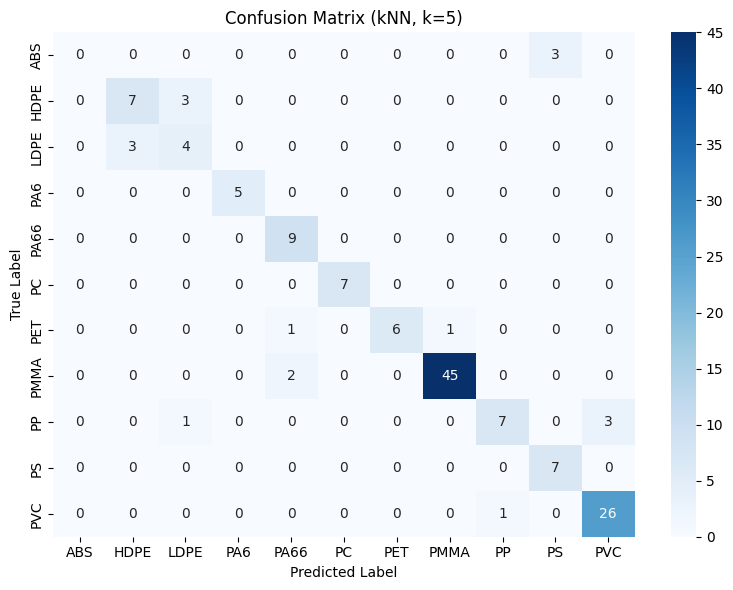

In [11]:
def prepare_spectral_data(filepath):
    """Load a spectral CSV and convert it into ML-ready format.
    
    Input:  CSV with wavelengths as rows, spectra as columns
    Output: X = feature matrix (n_samples x 128 features)
            y = label array (polymer name for each sample)
            wavelengths = the 128 wavelength values
    
    The key transformation is the TRANSPOSE (.T): in the CSV, each column
    is one spectrum (128 rows). But ML expects each ROW to be one sample.
    So we flip the matrix: (128 wavelengths x n_spectra) → (n_spectra x 128 features).
    """
    df = pd.read_csv(filepath)
    wavelengths = df.iloc[:, 0].values       # The wavelength column (1550-1950 nm)
    spectra_columns = df.columns[1:]         # Every other column is a spectrum
    
    # Transpose: each spectrum (column) becomes a row (sample)
    # .apply(pd.to_numeric, errors='coerce') ensures everything is a number
    X = df[spectra_columns].apply(pd.to_numeric, errors='coerce').values.T
    
    # Extract the polymer label from each column name
    y = np.array([extract_prefix(col) for col in spectra_columns])
    
    return X, y, wavelengths


def run_knn_classification(filepath, k=5, test_size=0.5):
    """Train and evaluate a standard kNN classifier on spectral data.
    
    Pipeline: load data → split → scale → train kNN → predict → evaluate
    """
    X, y, _ = prepare_spectral_data(filepath)
    
    # Split data: 50% for training, 50% for testing
    # stratify=y ensures each polymer is proportionally represented in both sets
    # random_state=42 makes the split reproducible (same split every time)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # StandardScaler: centre each of the 128 wavelength features to mean=0, std=1
    # This is ESSENTIAL for kNN because it uses Euclidean distance — without scaling,
    # wavelengths with larger raw values would dominate the distance calculation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Learn mean/std from training data, then scale it
    X_test_scaled = scaler.transform(X_test)         # Scale test data using the SAME mean/std (no peeking!)
    
    # Train the kNN model: k=5 means "look at the 5 nearest neighbours"
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)   # "Fitting" kNN just stores the training data — it's a lazy learner
    
    # Predict polymer labels for the test set
    y_pred = knn.predict(X_test_scaled)
    
    # Print evaluation metrics
    print(f'Occurrences of each polymer type in the test set:')
    test_counts = pd.Series(y_test).value_counts()
    print(test_counts)
    
    print(f'\nClassification Report (k={k}):')
    labels = sorted(np.unique(np.concatenate([y_test, y_pred])))
    print(classification_report(y_test, y_pred, labels=labels, zero_division=0))
    
    # Confusion matrix: rows = actual polymer, columns = predicted polymer
    # Diagonal = correct predictions, off-diagonal = misclassifications
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f'Confusion Matrix (kNN, k={k})')
    plt.tight_layout()
    plt.show()
    
    return knn, scaler


# ── Run Task 4.01 ────────────────────────────────────────────────────────────
# Train kNN with k=5 on the cleaned (post-outlier) dataset
knn_model, knn_scaler = run_knn_classification(outlier_checked_path, k=5)

**How to read the classification report:**

| Metric | What it means | Example |
|---|---|---|
| **Precision** | "Of all the times the model said 'PET', what fraction was actually PET?" | Precision = 0.80 means 80% of PET predictions were correct, 20% were wrong |
| **Recall** | "Of all the actual PET samples, what fraction did the model correctly identify?" | Recall = 0.90 means the model found 90% of PET samples, missed 10% |
| **F1-score** | The harmonic mean of precision and recall — a single number balancing both | High F1 = good at both finding the polymer AND not mislabelling others as it |
| **Support** | How many test samples exist for that polymer | Low support (e.g., 2-3) means the metric is unreliable for that class |

**How to read the confusion matrix:**
- Each **row** = the actual (true) polymer type.
- Each **column** = what the model predicted.
- **Diagonal cells** (top-left to bottom-right) = correct predictions.
- **Off-diagonal cells** = mistakes. For example, a "3" in row PVC / column PMMA means the model misidentified 3 PVC spectra as PMMA.

### Task 4.02: Building a Weighted-kNN Model

**Objective:** Improve on standard kNN with two enhancements: **distance weighting** and a **certainty threshold**.

**Problem with standard kNN:** All `k` neighbours get an equal vote, regardless of how close or far they are. A very distant neighbour (which might belong to a different class) counts just as much as the closest neighbour.

**Enhancement 1 — Distance weighting (`weights='distance'`):**
- Closer neighbours get a **stronger vote** than distant ones.
- Technically, each neighbour's vote is weighted by `1/distance` — so a neighbour at distance 0.1 has 10x more influence than one at distance 1.0.
- This makes the model less sensitive to outliers lurking at the edges of clusters.

**Enhancement 2 — Certainty threshold (0.6):**
- After predicting, the model checks its **confidence** (the fraction of weighted votes for the winning class).
- If confidence is below 60%, the prediction is labelled **"Uncertain"** instead of forcing a potentially wrong answer.
- **Why this matters for polymer recycling:** Misidentifying a polymer contaminates the recycling stream. It's better to flag a sample as "uncertain" and re-test it than to confidently give the wrong answer.

Occurrences of each polymer type in the test set:
PMMA    47
PVC     27
PP      11
HDPE    10
PA66     9
PET      8
LDPE     7
PS       7
PC       7
PA6      5
ABS      3
Name: count, dtype: int64

Prediction counts (including Uncertain):
PMMA         46
PVC          27
HDPE         10
PA66         10
Uncertain     8
PP            7
PS            7
PC            7
LDPE          6
PET           6
PA6           5
ABS           2
Name: count, dtype: int64

Classification Report (Weighted kNN, k=5, threshold=0.6):
              precision    recall  f1-score   support

         ABS       1.00      0.67      0.80         3
        HDPE       0.90      0.90      0.90        10
        LDPE       0.67      0.57      0.62         7
         PA6       1.00      1.00      1.00         5
        PA66       0.90      1.00      0.95         9
          PC       1.00      1.00      1.00         7
         PET       1.00      0.75      0.86         8
        PMMA       0.98      0.96      0.97        

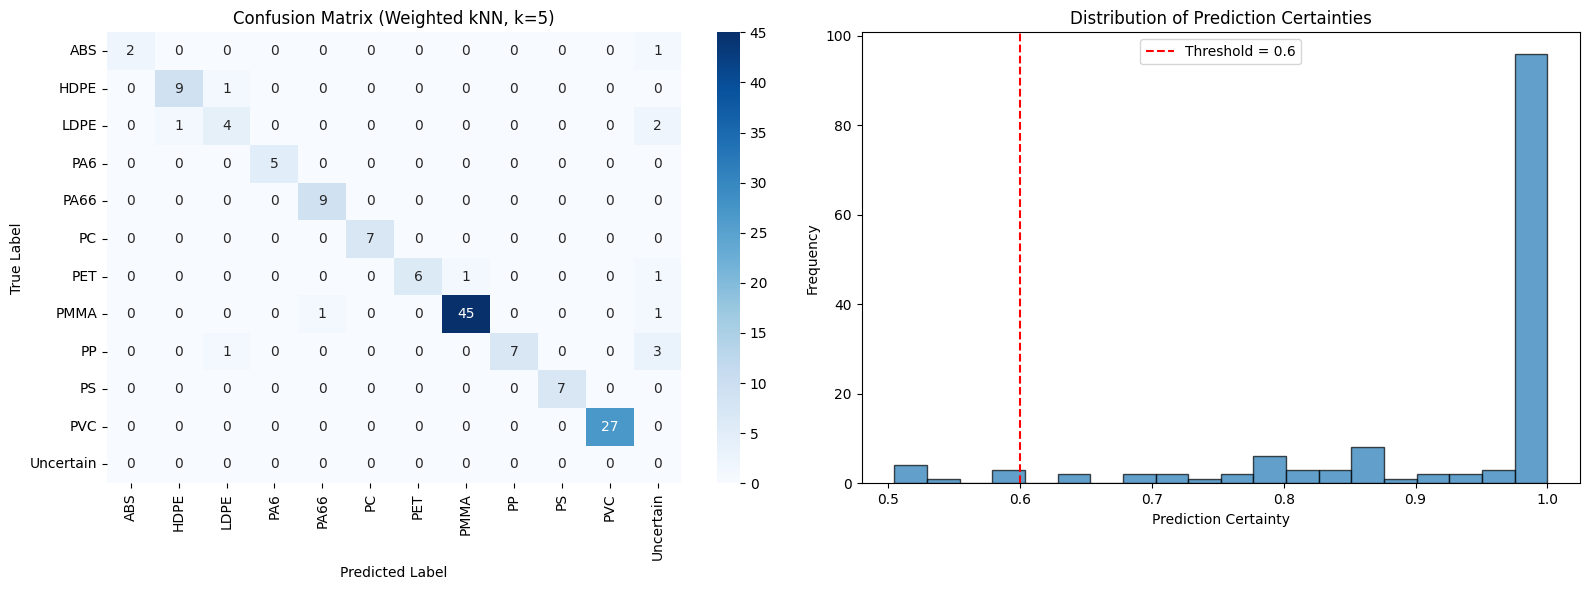

In [12]:
def run_weighted_knn(filepath, k=5, test_size=0.5, certainty_threshold=0.6):
    """Train and evaluate a distance-weighted kNN with a certainty threshold."""
    X, y, _ = prepare_spectral_data(filepath)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Weighted kNN: weights='distance' gives closer neighbours more influence
    wknn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    wknn.fit(X_train_scaled, y_train)
    
    # Predict with probabilities
    y_proba = wknn.predict_proba(X_test_scaled)
    y_pred_raw = wknn.predict(X_test_scaled)
    certainties = np.max(y_proba, axis=1)
    
    # Apply certainty threshold
    y_pred = np.where(certainties >= certainty_threshold, y_pred_raw, 'Uncertain')
    
    # Counts
    print('Occurrences of each polymer type in the test set:')
    print(pd.Series(y_test).value_counts())
    print(f'\nPrediction counts (including Uncertain):')
    print(pd.Series(y_pred).value_counts())
    
    # Classification report
    all_labels = sorted(set(list(y_test) + list(y_pred)))
    print(f'\nClassification Report (Weighted kNN, k={k}, threshold={certainty_threshold}):')
    print(classification_report(y_test, y_pred, labels=all_labels, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=all_labels)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_labels, yticklabels=all_labels, ax=axes[0])
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    axes[0].set_title(f'Confusion Matrix (Weighted kNN, k={k})')
    
    # Certainty histogram
    axes[1].hist(certainties, bins=20, edgecolor='black', alpha=0.7)
    axes[1].axvline(x=certainty_threshold, color='red', linestyle='--',
                    label=f'Threshold = {certainty_threshold}')
    axes[1].set_xlabel('Prediction Certainty')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Prediction Certainties')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return wknn, scaler


# Run Task 4.02
wknn_model, wknn_scaler = run_weighted_knn(outlier_checked_path, k=5, certainty_threshold=0.6)

The certainty histogram shows how confident the model is across all test predictions. Predictions below the threshold are labelled "Uncertain" — this is preferable to misidentification in a real-world recycling context, where misidentified polymers could contaminate the recycling stream.

### Task 4.03: Extension — Grid Search and SVM

**Objective:** Try two additional approaches to improve classification:

**1. Grid search for optimal `k`:**
- So far we've used k=5 (look at 5 neighbours), but is 5 the best choice? Maybe k=3 or k=11 works better.
- **Grid search** systematically tries every combination of `k` from 1 to 20 and `weights` (uniform vs distance), evaluates each using **5-fold cross-validation** (splits the training data 5 ways and averages performance), and picks the best combination.
- `scoring='f1_macro'` means we optimise for the macro-averaged F1 score — this gives equal importance to all polymer classes regardless of how many spectra they have.

**2. Support Vector Machine (SVM) as an alternative classifier:**
- SVM works differently from kNN: instead of finding nearest neighbours, it finds the **optimal boundary** (hyperplane) that separates the polymer classes in feature space.
- The **RBF (Radial Basis Function) kernel** allows SVM to draw curved (non-linear) boundaries, which can better separate classes that aren't linearly separable in the 128-dimensional wavelength space.
- Comparing SVM to kNN tells us whether a fundamentally different algorithm performs better on this data.

=== Grid Search for Optimal kNN Parameters ===


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'n_neighbors': 2, 'weights': 'uniform'}
Best cross-validation F1 score: 0.866

Test set Classification Report (optimised kNN):
              precision    recall  f1-score   support

         ABS       0.75      1.00      0.86         3
        HDPE       0.91      1.00      0.95        10
        LDPE       0.86      0.86      0.86         7
         PA6       1.00      1.00      1.00         5
        PA66       0.82      1.00      0.90         9
          PC       1.00      1.00      1.00         7
         PET       1.00      1.00      1.00         8
        PMMA       1.00      0.94      0.97        47
          PP       1.00      0.91      0.95        11
          PS       1.00      1.00      1.00         7
         PVC       1.00      1.00      1.00        27

    accuracy                           0.96       141
   macro avg       0.94      0.97      0.95       141
weighted avg       0.97      0.96      0.97       141


=== SVM Classifier ===
SVM Classification

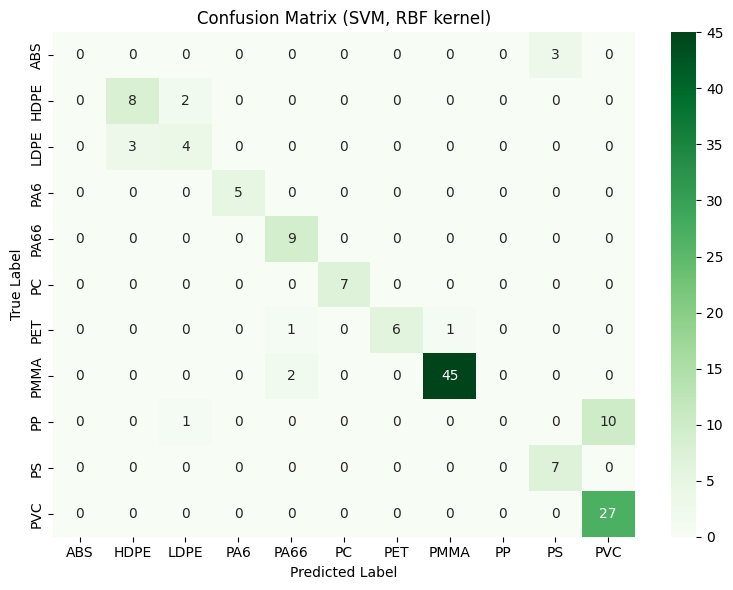

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


def grid_search_knn(filepath, test_size=0.5):
    """Find optimal k for kNN using grid search with cross-validation."""
    X, y, _ = prepare_spectral_data(filepath)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Grid search over k values
    param_grid = {'n_neighbors': list(range(1, 21)), 'weights': ['uniform', 'distance']}
    grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1_macro')
    grid.fit(X_train_scaled, y_train)
    
    print(f'Best parameters: {grid.best_params_}')
    print(f'Best cross-validation F1 score: {grid.best_score_:.3f}')
    
    # Evaluate on test set
    y_pred = grid.predict(X_test_scaled)
    labels = sorted(np.unique(np.concatenate([y_test, y_pred])))
    print(f'\nTest set Classification Report (optimised kNN):')
    print(classification_report(y_test, y_pred, labels=labels, zero_division=0))
    return grid


def run_svm_classification(filepath, test_size=0.5):
    """Train and evaluate an SVM classifier for comparison."""
    X, y, _ = prepare_spectral_data(filepath)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train_scaled, y_train)
    y_pred = svm.predict(X_test_scaled)
    
    labels = sorted(np.unique(np.concatenate([y_test, y_pred])))
    print('SVM Classification Report:')
    print(classification_report(y_test, y_pred, labels=labels, zero_division=0))
    
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix (SVM, RBF kernel)')
    plt.tight_layout()
    plt.show()
    return svm


# Run grid search
print('=== Grid Search for Optimal kNN Parameters ===')
best_knn = grid_search_knn(outlier_checked_path)

print('\n=== SVM Classifier ===')
svm_model = run_svm_classification(outlier_checked_path)

Comparing the optimised kNN, weighted kNN, and SVM results helps determine which model is best suited for this spectral classification task. SVM with an RBF kernel can capture non-linear decision boundaries, which may improve classification of spectrally similar polymers.

### Comparing Model Performance: Before vs After Outlier Removal

**Objective:** Quantify the impact of the outlier removal step (Task 3.02) on classification accuracy. Three models -- standard kNN (k=5), distance-weighted kNN (k=5), and SVM (RBF kernel) -- are trained and evaluated on both the pre-outlier dataset (`2.07_checked-data.csv`) and the post-outlier dataset (`3.02_outlier-checked-data.csv`). Overall accuracy and macro-averaged F1-score are compared side-by-side to determine whether removing outlier spectra improves model performance.

In [14]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_models_on_dataset(filepath, dataset_label):
    """Train kNN, weighted kNN, and SVM on a dataset; return accuracy, macro F1, and per-class F1."""
    X, y, _ = prepare_spectral_data(filepath)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    class_labels = sorted(np.unique(y))
    results = []

    models = [
        ('kNN (k=5)', KNeighborsClassifier(n_neighbors=5)),
        ('Weighted kNN (k=5)', KNeighborsClassifier(n_neighbors=5, weights='distance')),
        ('SVM (RBF)', SVC(kernel='rbf', random_state=42)),
    ]

    for model_name, model in models:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        row = {
            'Dataset': dataset_label,
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Macro F1': f1_score(y_test, y_pred, average='macro', zero_division=0),
        }

        # Per-class F1 scores
        per_class = f1_score(y_test, y_pred, labels=class_labels, average=None, zero_division=0)
        for cls, score in zip(class_labels, per_class):
            row[f'F1 {cls}'] = score

        results.append(row)

    return results, class_labels


# Evaluate on both datasets
before_results, class_labels_before = evaluate_models_on_dataset(checked_path, 'Before Outlier Removal')
after_results, class_labels_after = evaluate_models_on_dataset(outlier_checked_path, 'After Outlier Removal')

# Combine into a comparison DataFrame
comparison_df = pd.DataFrame(before_results + after_results)

# Identify per-class F1 columns
all_class_labels = sorted(set(class_labels_before) | set(class_labels_after))
per_class_cols = [f'F1 {cls}' for cls in all_class_labels]

# Format numeric columns
for col in ['Accuracy', 'Macro F1'] + per_class_cols:
    if col in comparison_df.columns:
        comparison_df[col] = comparison_df[col].map('{:.3f}'.format)

# --- Summary table (Accuracy + Macro F1) ---
summary_cols = ['Dataset', 'Model', 'Accuracy', 'Macro F1']
pivot_acc = comparison_df.pivot(index='Model', columns='Dataset', values='Accuracy')
pivot_f1 = comparison_df.pivot(index='Model', columns='Dataset', values='Macro F1')

print('=== Accuracy Comparison ===')
print(pivot_acc[['Before Outlier Removal', 'After Outlier Removal']].to_string())
print()
print('=== Macro-Averaged F1 Comparison ===')
print(pivot_f1[['Before Outlier Removal', 'After Outlier Removal']].to_string())
print()

# --- Per-class F1 table ---
print('=== Per-Class F1 Scores ===')
display_cols = ['Dataset', 'Model'] + per_class_cols
print(comparison_df[display_cols].to_string(index=False))
print()

# --- Full table ---
print('=== Full Comparison Table ===')
print(comparison_df.to_string(index=False))


=== Accuracy Comparison ===
Dataset            Before Outlier Removal After Outlier Removal
Model                                                          
SVM (RBF)                           0.772                 0.837
Weighted kNN (k=5)                  0.898                 0.922
kNN (k=5)                           0.862                 0.872

=== Macro-Averaged F1 Comparison ===
Dataset            Before Outlier Removal After Outlier Removal
Model                                                          
SVM (RBF)                           0.617                 0.698
Weighted kNN (k=5)                  0.908                 0.902
kNN (k=5)                           0.833                 0.764

=== Per-Class F1 Scores ===
               Dataset              Model F1 ABS F1 HDPE F1 LDPE F1 PA6 F1 PA66 F1 PC F1 PET F1 PMMA F1 PP F1 PS F1 PVC
Before Outlier Removal          kNN (k=5)  0.667   0.870   0.778  1.000   0.909 0.824  0.800   0.903 0.632 0.933  0.853
Before Outlier Removal We

**Interpretation:**

The tables above show how each model's accuracy, macro-averaged F1-score, and per-class F1-scores change after outlier removal. Key observations:

- If the **After** scores are higher, outlier removal successfully cleaned noisy or mislabelled spectra that were confusing the classifiers. This confirms the value of the Pearson correlation-based outlier detection in Task 3.02.
- If the scores are similar or slightly lower, the removed spectra may not have been harming classification -- or the smaller dataset may have reduced the model's ability to generalise.
- The **macro-averaged F1** is particularly informative for imbalanced datasets because it weights all polymer classes equally, preventing high-frequency classes from masking poor performance on rare ones.
- The **per-class F1 scores** reveal which specific polymer types benefit most from outlier removal. Polymers that had outlier spectra removed should show the largest improvements, since noisy samples in those classes would have distorted the decision boundaries.
- Among the three models, SVM (RBF) typically benefits the most from outlier removal because support vectors near the decision boundary are sensitive to noisy data points.


---
## Activity 5: Identifying Your Unknown Polymers

**Objective:** Use the best-performing trained model to classify the 10 unknown polymer samples. The unknown spectra must first be processed through the same pipeline (transform, check for invalid values) before being fed to the model.

*Update the `UNKNOWN_CSV` path below once you have collected the unknown spectra using PlasTell.*

In [15]:
# Placeholder: update this path with your actual unknown samples export
UNKNOWN_CSV = os.path.join(DATA_DIR, 'unknown_samples.csv')  # UPDATE THIS


def identify_unknowns(model, scaler, unknown_filepath, reference_filepath):
    """Process unknown spectra and predict polymer identity."""
    if not os.path.exists(unknown_filepath):
        print(f'Unknown samples file not found: {unknown_filepath}')
        print('Please collect unknown spectra and update the UNKNOWN_CSV path.')
        return None
    
    # Load and transform unknown data (same pipeline as training data)
    unknown_raw = pd.read_csv(unknown_filepath)
    unknown_raw['spectrum'] = unknown_raw['spectrum'].apply(ast.literal_eval)
    
    X_unknown = np.array(unknown_raw['spectrum'].tolist())
    X_unknown_scaled = scaler.transform(X_unknown)
    
    # Predict
    predictions = model.predict(X_unknown_scaled)
    
    # If model supports predict_proba, show certainties
    if hasattr(model, 'predict_proba'):
        probas = model.predict_proba(X_unknown_scaled)
        certainties = np.max(probas, axis=1)
    else:
        certainties = ['N/A'] * len(predictions)
    
    results = pd.DataFrame({
        'Sample': range(1, len(predictions) + 1),
        'Predicted Polymer': predictions,
        'Certainty': certainties
    })
    
    print('Unknown Sample Predictions:')
    print(results.to_string(index=False))
    return results


# Run Task 5 (will print guidance if unknown file doesn't exist yet)
unknown_results = identify_unknowns(wknn_model, wknn_scaler, UNKNOWN_CSV, outlier_checked_path)

Unknown samples file not found: ./data/unknown_samples.csv
Please collect unknown spectra and update the UNKNOWN_CSV path.


**Critical assessment:** When evaluating the model's predictions on unknown samples, consider:
- Are the certainty values consistently high? Low certainty may indicate the unknown polymer is not well-represented in the training data.
- Could the unknown polymer be a type not present in the reference database? kNN will always assign one of the known classes, even if the true answer is none of them.
- Physical/chemical factors such as polymer colour, thickness, additives, and surface texture can all influence the NIR spectrum and reduce classification accuracy.

---
### PCA Visualisation of Polymer Feature Space

**Principal Component Analysis (PCA)** is a dimensionality reduction technique that projects high-dimensional data (here, 128 wavelength features per spectrum) onto a smaller set of orthogonal axes called **principal components**. Each component captures the maximum remaining variance in the data.

For NIR spectral data, PCA is useful because:
- It reveals the **natural clustering** of polymer types in a reduced feature space.
- It shows whether polymers that are spectrally similar (and therefore harder to classify) overlap in the low-dimensional projection.
- The **scree plot** indicates how many components are needed to capture most of the variance — if the first 2–3 components explain >90% of variance, the spectral differences between polymers are dominated by a few key absorption features.
- Overlaying outlier spectra on the PCA projection shows whether removed outliers genuinely fall outside the main clusters.

Post-outlier dataset: 282 spectra, 128 features
Explained variance (first 10 PCs): 99.6%
Per-component: ['44.9%', '31.9%', '8.0%', '6.4%', '5.9%', '0.9%', '0.7%', '0.4%', '0.4%', '0.2%']


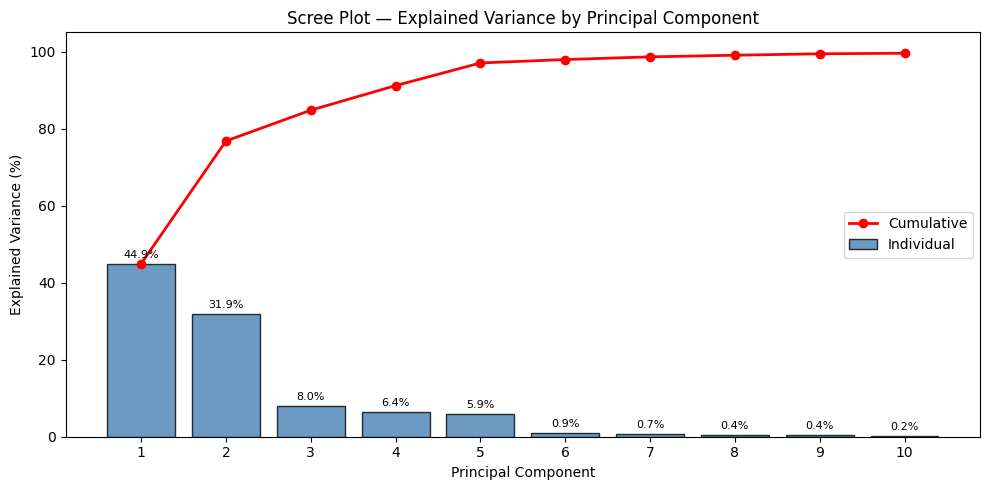

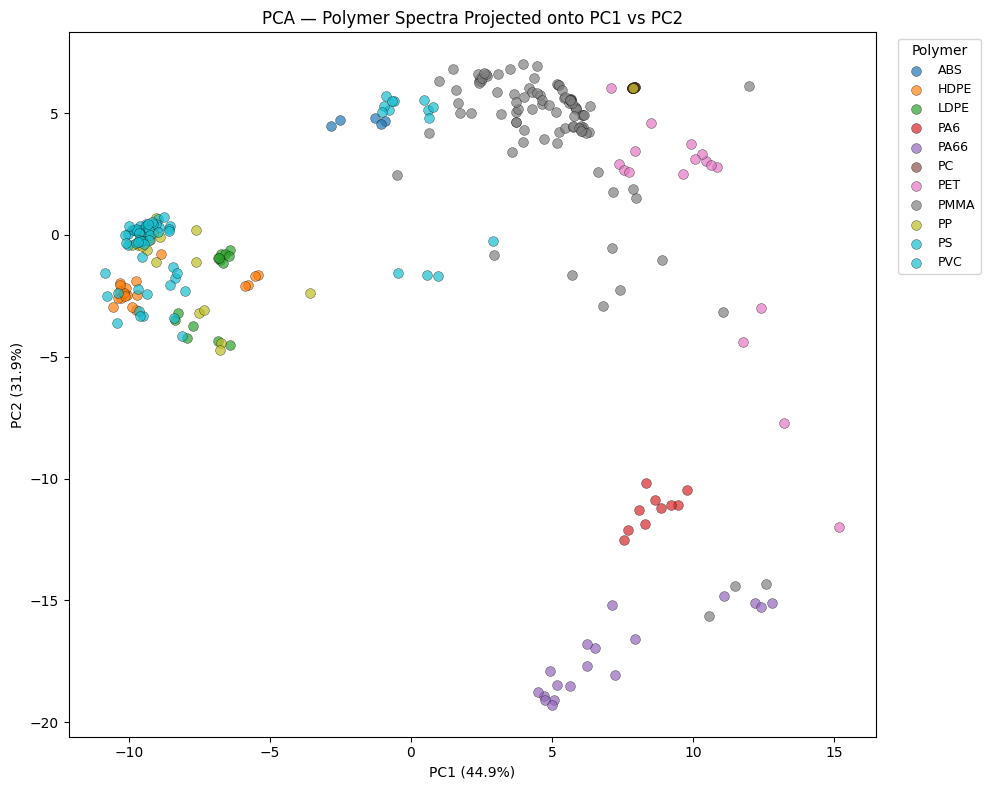

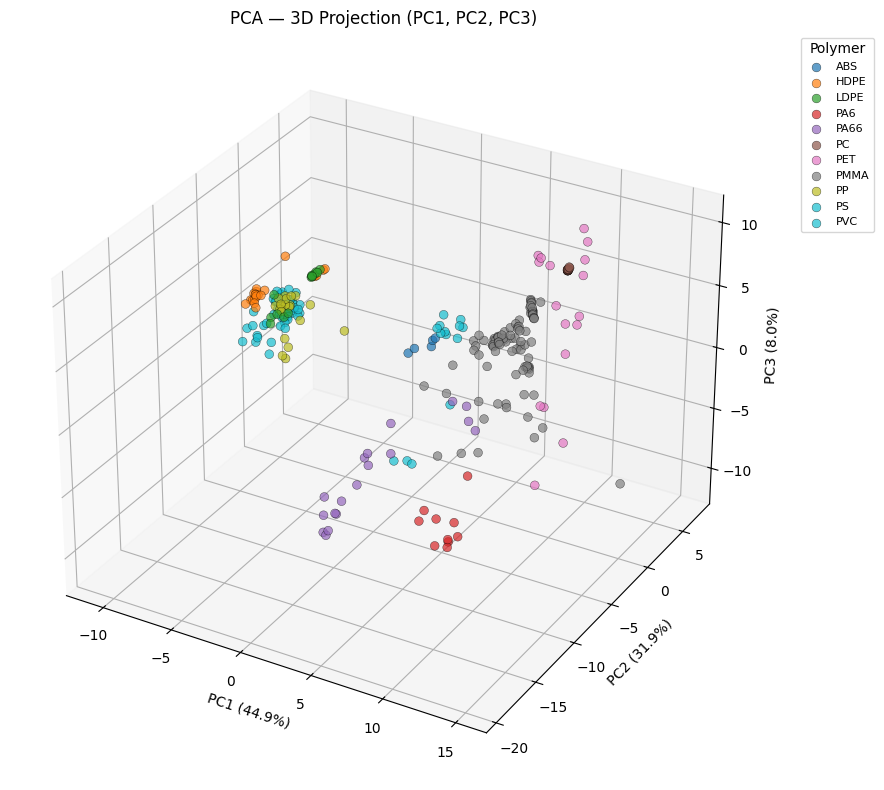

Outlier spectra identified: 51
  Columns: ['HDPE.15', 'HDPE.16', 'HDPE.17', 'HDPE.18', 'HDPE.19', 'LDPE.03', 'PA66.17', 'PA66.5', 'PET.13', 'PMMA.105', 'PMMA.106', 'PMMA.109', 'PMMA.110', 'PMMA.111', 'PMMA.112', 'PMMA.113', 'PMMA.25', 'PMMA.26', 'PMMA.27', 'PMMA.28', 'PMMA.29', 'PMMA.85', 'PMMA.86', 'PMMA.87', 'PMMA.88', 'PMMA.89', 'PMMA.90', 'PMMA.91', 'PMMA.92', 'PMMA.94', 'PP.20', 'PP.21', 'PP.22', 'PP.23', 'PP.24', 'PS.10', 'PVC', 'PVC.01', 'PVC.02', 'PVC.3', 'PVC.4', 'PVC.50', 'PVC.51', 'PVC.52', 'PVC.53', 'PVC.54', 'PVC.55', 'PVC.56', 'PVC.57', 'PVC.58', 'PVC.59']


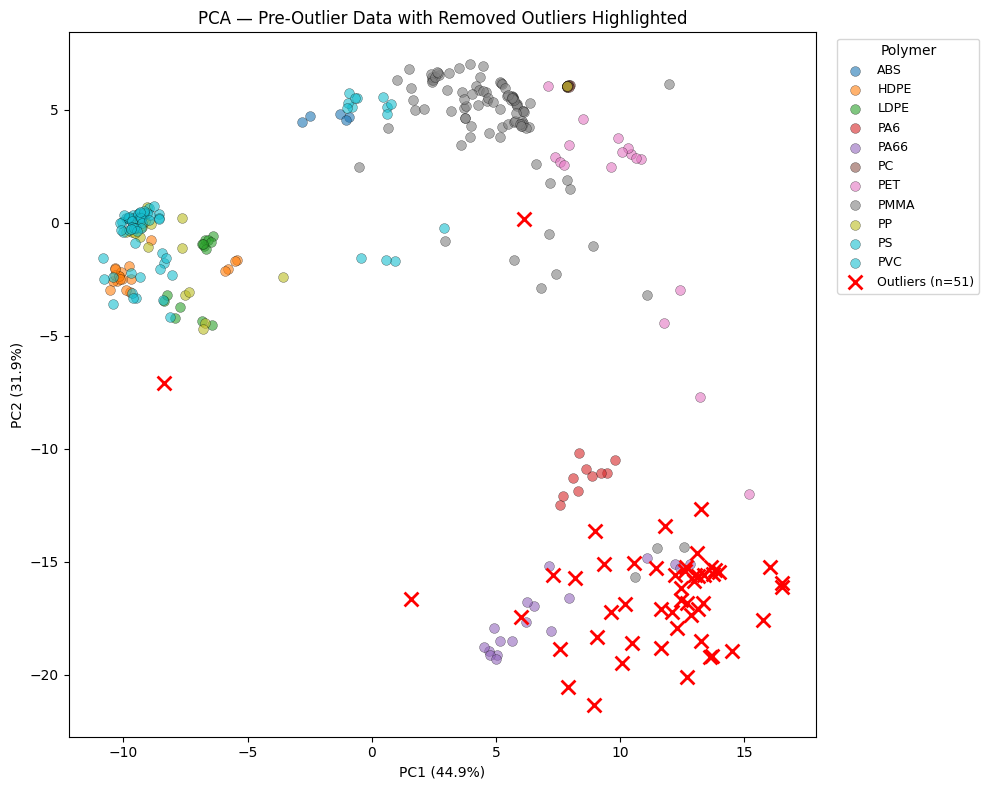

In [16]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# ── 1. Load cleaned (post-outlier) data and fit PCA ──────────────────────────
X_clean, y_clean, wl_clean = prepare_spectral_data(outlier_checked_path)

scaler_pca = StandardScaler()
X_clean_scaled = scaler_pca.fit_transform(X_clean)

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_clean_scaled)

print(f'Post-outlier dataset: {X_clean.shape[0]} spectra, {X_clean.shape[1]} features')
print(f'Explained variance (first 10 PCs): {pca.explained_variance_ratio_.sum():.1%}')
print(f'Per-component: {[f"{v:.1%}" for v in pca.explained_variance_ratio_]}')

# ── 2. Scree plot ─────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))
components = np.arange(1, 11)
bars = ax.bar(components, pca.explained_variance_ratio_ * 100, color='steelblue',
              edgecolor='black', alpha=0.8, label='Individual')
cumulative = np.cumsum(pca.explained_variance_ratio_) * 100
ax.plot(components, cumulative, 'ro-', linewidth=2, label='Cumulative')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance (%)')
ax.set_title('Scree Plot — Explained Variance by Principal Component')
ax.set_xticks(components)
ax.legend(loc='center right')
ax.set_ylim(0, 105)
for i, (bar, val) in enumerate(zip(bars, pca.explained_variance_ratio_ * 100)):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# ── 3. 2D scatter plot (PC1 vs PC2) ──────────────────────────────────────────
unique_labels = sorted(np.unique(y_clean))
cmap = plt.cm.tab10
colors = {label: cmap(i / max(len(unique_labels) - 1, 1)) for i, label in enumerate(unique_labels)}

fig, ax = plt.subplots(figsize=(10, 8))
for label in unique_labels:
    mask = y_clean == label
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=[colors[label]], label=label, s=50, alpha=0.7, edgecolors='k', linewidths=0.3)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA — Polymer Spectra Projected onto PC1 vs PC2')
ax.legend(title='Polymer', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

# ── 4. 3D scatter plot (PC1 vs PC2 vs PC3) ───────────────────────────────────
fig = plt.figure(figsize=(11, 8))
ax3d = fig.add_subplot(111, projection='3d')
for label in unique_labels:
    mask = y_clean == label
    ax3d.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
                 c=[colors[label]], label=label, s=40, alpha=0.7, edgecolors='k', linewidths=0.3)
ax3d.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax3d.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax3d.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})')
ax3d.set_title('PCA — 3D Projection (PC1, PC2, PC3)')
ax3d.legend(title='Polymer', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

# ── 5. Overlay plot: pre-outlier data with outliers highlighted ───────────────
X_pre, y_pre, _ = prepare_spectral_data(checked_path)
X_post, y_post, _ = prepare_spectral_data(outlier_checked_path)

# Identify outlier columns: present in pre-outlier but absent from post-outlier
df_pre = pd.read_csv(checked_path)
df_post = pd.read_csv(outlier_checked_path)
pre_cols = set(df_pre.columns[1:])
post_cols = set(df_post.columns[1:])
outlier_col_names = pre_cols - post_cols
print(f'Outlier spectra identified: {len(outlier_col_names)}')
if outlier_col_names:
    print(f'  Columns: {sorted(outlier_col_names)}')

# Scale ALL pre-outlier data using the same scaler fitted on clean data
X_pre_scaled = scaler_pca.transform(X_pre)
X_pre_pca = pca.transform(X_pre_scaled)

# Build mask: True for outlier spectra
pre_col_list = list(df_pre.columns[1:])
outlier_mask = np.array([col in outlier_col_names for col in pre_col_list])
normal_mask = ~outlier_mask

fig, ax = plt.subplots(figsize=(10, 8))

# Plot normal (non-outlier) points coloured by polymer
for label in unique_labels:
    mask = (y_pre == label) & normal_mask
    if mask.any():
        ax.scatter(X_pre_pca[mask, 0], X_pre_pca[mask, 1],
                   c=[colors[label]], label=label, s=50, alpha=0.6,
                   edgecolors='k', linewidths=0.3)

# Plot outliers with red 'x' markers
if outlier_mask.any():
    ax.scatter(X_pre_pca[outlier_mask, 0], X_pre_pca[outlier_mask, 1],
               c='red', marker='x', s=100, linewidths=2, zorder=5,
               label=f'Outliers (n={outlier_mask.sum()})')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA — Pre-Outlier Data with Removed Outliers Highlighted')
ax.legend(title='Polymer', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

**Interpreting the PCA results:**

- **Scree plot:** The first few principal components typically capture the majority of spectral variance. A sharp "elbow" in the scree plot indicates that most meaningful variation is concentrated in just 2--3 dimensions, which is expected for NIR data where polymer identity is primarily encoded in a handful of absorption bands.

- **2D scatter (PC1 vs PC2):** Well-separated clusters indicate that the corresponding polymers have distinct spectral signatures and should be easy to classify. Overlapping clusters suggest spectral similarity between those polymer types -- these are the pairs most likely to be confused by kNN or SVM classifiers (consistent with off-diagonal entries in the confusion matrices above).

- **3D scatter (PC1--PC3):** Adding the third component can resolve clusters that overlap in the 2D projection. If two polymer groups overlap in PC1-PC2 but separate along PC3, this indicates that a third spectral feature distinguishes them.

- **Outlier overlay:** Outlier spectra (red crosses) that fall far from their polymer's cluster confirm that the Pearson correlation-based detection in Task 3.02 correctly identified anomalous measurements. Outliers that fall *within* another polymer's cluster may represent mislabelled samples or contaminated measurements. The spatial separation between outliers and their nominal class provides visual justification for their removal from the training data.

### Addressing Class Imbalance

The dataset is severely imbalanced — some polymer classes (e.g., PMMA) have many more spectra than others (e.g., ABS with only a handful). Standard kNN treats all training samples equally, so it is biased toward predicting the majority class. This means minority classes may be consistently misclassified even when the model reports high overall accuracy.

Three strategies are compared below:
1. **SMOTE (Synthetic Minority Oversampling Technique):** Generates synthetic training samples for minority classes by interpolating between existing minority-class neighbours. This balances the training set without discarding data.
2. **Random Undersampling:** Reduces the majority class(es) by randomly removing training samples until all classes have equal representation. Simple but discards potentially useful data.
3. **Class-Weighted kNN:** Instead of modifying the training data, sample weights inversely proportional to class frequency are used during training so that minority-class samples carry more influence.

All resampling is applied **only to the training set** to avoid data leakage into the test set.

Training set class distribution (before resampling):
PMMA    47
PVC     28
HDPE    10
PP      10
PET      9
PA66     9
PS       7
PC       7
LDPE     7
PA6      5
ABS      2
Name: count, dtype: int64

=== Baseline kNN (no balancing) ===
              precision    recall  f1-score   support

         ABS       0.00      0.00      0.00         3
        HDPE       0.70      0.70      0.70        10
        LDPE       0.50      0.57      0.53         7
         PA6       1.00      1.00      1.00         5
        PA66       0.75      1.00      0.86         9
          PC       1.00      1.00      1.00         7
         PET       1.00      0.75      0.86         8
        PMMA       0.98      0.96      0.97        47
          PP       0.88      0.64      0.74        11
          PS       0.70      1.00      0.82         7
         PVC       0.90      0.96      0.93        27

    accuracy                           0.87       141
   macro avg       0.76      0.78      0.76       141
weigh

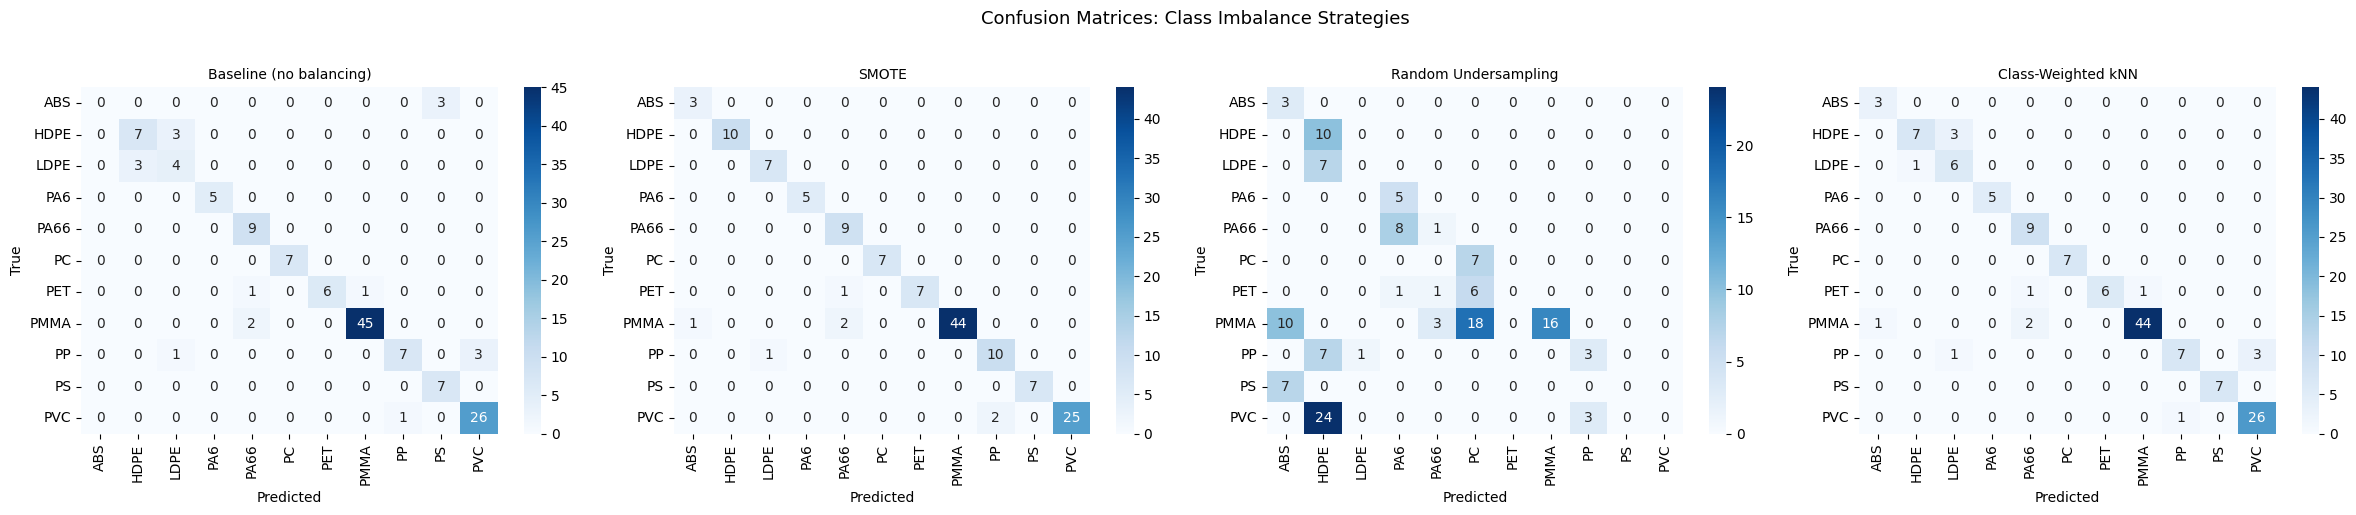

In [17]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_sample_weight

# --- Load and split the cleaned data ---
X_imb, y_imb, _ = prepare_spectral_data(outlier_checked_path)

X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_imb, y_imb, test_size=0.5, random_state=42, stratify=y_imb
)

scaler_imb = StandardScaler()
X_train_scaled_imb = scaler_imb.fit_transform(X_train_imb)
X_test_scaled_imb = scaler_imb.transform(X_test_imb)

print('Training set class distribution (before resampling):')
print(pd.Series(y_train_imb).value_counts())
print()

# Store results for comparison
results_list = []

# -------------------------------------------------------------------
# 1. Baseline: standard kNN (no balancing)
# -------------------------------------------------------------------
knn_baseline = KNeighborsClassifier(n_neighbors=5)
knn_baseline.fit(X_train_scaled_imb, y_train_imb)
y_pred_baseline = knn_baseline.predict(X_test_scaled_imb)

report_baseline = classification_report(
    y_test_imb, y_pred_baseline, output_dict=True, zero_division=0
)
results_list.append({
    'Method': 'Baseline (no balancing)',
    'Macro F1': report_baseline['macro avg']['f1-score'],
    'Weighted F1': report_baseline['weighted avg']['f1-score'],
    'Accuracy': report_baseline['accuracy']
})

print('=== Baseline kNN (no balancing) ===')
print(classification_report(y_test_imb, y_pred_baseline, zero_division=0))

# -------------------------------------------------------------------
# 2. SMOTE oversampling on training set
# -------------------------------------------------------------------
# SMOTE needs at least k_neighbors+1 samples per minority class.
# Determine a safe k_neighbors value for SMOTE.
min_train_count = min(Counter(y_train_imb).values())
smote_k = min(5, min_train_count - 1) if min_train_count > 1 else 1

smote = SMOTE(random_state=42, k_neighbors=smote_k)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled_imb, y_train_imb)

print(f'SMOTE resampled training set distribution (k_neighbors={smote_k}):')
print(pd.Series(y_train_smote).value_counts())
print()

knn_smote = KNeighborsClassifier(n_neighbors=5)
knn_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = knn_smote.predict(X_test_scaled_imb)

report_smote = classification_report(
    y_test_imb, y_pred_smote, output_dict=True, zero_division=0
)
results_list.append({
    'Method': 'SMOTE oversampling',
    'Macro F1': report_smote['macro avg']['f1-score'],
    'Weighted F1': report_smote['weighted avg']['f1-score'],
    'Accuracy': report_smote['accuracy']
})

print('=== SMOTE Oversampling ===')
print(classification_report(y_test_imb, y_pred_smote, zero_division=0))

# -------------------------------------------------------------------
# 3. Random undersampling on training set
# -------------------------------------------------------------------
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled_imb, y_train_imb)

print('Undersampled training set distribution:')
print(pd.Series(y_train_rus).value_counts())
print()

knn_rus = KNeighborsClassifier(n_neighbors=5)
knn_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = knn_rus.predict(X_test_scaled_imb)

report_rus = classification_report(
    y_test_imb, y_pred_rus, output_dict=True, zero_division=0
)
results_list.append({
    'Method': 'Random undersampling',
    'Macro F1': report_rus['macro avg']['f1-score'],
    'Weighted F1': report_rus['weighted avg']['f1-score'],
    'Accuracy': report_rus['accuracy']
})

print('=== Random Undersampling ===')
print(classification_report(y_test_imb, y_pred_rus, zero_division=0))

# -------------------------------------------------------------------
# 4. Class-weighted kNN using sample weights
# -------------------------------------------------------------------
# sklearn's KNeighborsClassifier does not natively support class_weight,
# so we use a distance-weighted kNN and compute inverse-frequency sample
# weights via compute_sample_weight('balanced', ...). We wrap the
# approach by fitting on the original training set but weighting
# neighbours by class frequency during prediction using a custom scorer.
#
# Practical approach: use compute_sample_weight to get per-sample weights,
# then duplicate minority samples proportionally to approximate weighting.

sample_weights = compute_sample_weight('balanced', y_train_imb)

# Duplicate samples according to their weight (rounded to integers)
repeat_counts = np.round(sample_weights).astype(int)
repeat_counts = np.maximum(repeat_counts, 1)  # At least 1 copy

X_train_weighted = np.repeat(X_train_scaled_imb, repeat_counts, axis=0)
y_train_weighted = np.repeat(y_train_imb, repeat_counts, axis=0)

print('Class-weighted (duplicated) training set distribution:')
print(pd.Series(y_train_weighted).value_counts())
print()

knn_weighted = KNeighborsClassifier(n_neighbors=5)
knn_weighted.fit(X_train_weighted, y_train_weighted)
y_pred_weighted = knn_weighted.predict(X_test_scaled_imb)

report_weighted = classification_report(
    y_test_imb, y_pred_weighted, output_dict=True, zero_division=0
)
results_list.append({
    'Method': 'Class-weighted kNN',
    'Macro F1': report_weighted['macro avg']['f1-score'],
    'Weighted F1': report_weighted['weighted avg']['f1-score'],
    'Accuracy': report_weighted['accuracy']
})

print('=== Class-Weighted kNN ===')
print(classification_report(y_test_imb, y_pred_weighted, zero_division=0))

# -------------------------------------------------------------------
# Comparison table
# -------------------------------------------------------------------
comparison_df = pd.DataFrame(results_list)
comparison_df = comparison_df.set_index('Method')
comparison_df = comparison_df.round(4)

print('\n' + '=' * 60)
print('CLASS IMBALANCE STRATEGY COMPARISON')
print('=' * 60)
print(comparison_df.to_string())
print('=' * 60)

# --- Confusion matrices side-by-side ---
labels_imb = sorted(np.unique(np.concatenate([y_test_imb, y_pred_baseline])))

fig, axes = plt.subplots(1, 4, figsize=(24, 5))
titles = ['Baseline (no balancing)', 'SMOTE', 'Random Undersampling', 'Class-Weighted kNN']
predictions = [y_pred_baseline, y_pred_smote, y_pred_rus, y_pred_weighted]

for ax, title, y_pred in zip(axes, titles, predictions):
    cm = confusion_matrix(y_test_imb, y_pred, labels=labels_imb)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_imb, yticklabels=labels_imb, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title, fontsize=10)

plt.suptitle('Confusion Matrices: Class Imbalance Strategies', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

**Interpreting the class imbalance results:**

The comparison table above shows how each balancing strategy affects classification performance:

- **Macro F1** treats all classes equally regardless of size, making it the most important metric when minority-class performance matters (e.g., correctly identifying a rare polymer in a recycling stream).
- **Weighted F1** gives more importance to larger classes, so it tends to look favourable even when minority classes are poorly classified.
- **Accuracy** can be misleading with imbalanced data — a model that always predicts the majority class can still achieve high accuracy.

**Trade-offs between approaches:**

| Strategy | Pros | Cons |
|---|---|---|
| SMOTE | Preserves all real data; generates plausible synthetic samples | May create unrealistic spectra if classes overlap in feature space; requires enough minority samples to interpolate |
| Random Undersampling | Simple; fast; no synthetic data | Discards majority-class data that may contain useful information; high variance with very small datasets |
| Class-Weighted kNN | No data modification; accounts for imbalance during model fitting | Approximate (uses sample duplication); may over-represent noisy minority samples |

In practice, the best strategy depends on the degree of imbalance and the number of available samples. When minority classes have very few spectra (e.g., fewer than 5), SMOTE may struggle because it needs neighbours to interpolate between, while undersampling would reduce the training set to an impractically small size. In such cases, class-weighted approaches or collecting additional data for under-represented polymers may be the most practical solution.